In [ ]:
# import necessary libraries

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.metrics import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import RepeatVector,TimeDistributed
from numpy import array
from keras.models import Sequential, load_model

import re
from tqdm import tqdm
import os
from  datetime import datetime, timedelta




In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mhshakil","key":"0b2b948031b3bce6c18c207033b4015f"}'}

In [ ]:
#Make directory name kaggle
! mkdir ~/.kaggle

In [ ]:
#Copy the json kaggle to this directory
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c m5-forecasting-accuracy

 72% 33.0M/45.8M [00:00<00:00, 51.0MB/s]
100% 45.8M/45.8M [00:00<00:00, 59.7MB/s]


In [ ]:
! mkdir m5_data

In [ ]:
! unzip m5-forecasting-accuracy.zip -d m5_data

Archive:  m5-forecasting-accuracy.zip
  inflating: m5_data/calendar.csv    
  inflating: m5_data/sales_train_evaluation.csv  
  inflating: m5_data/sales_train_validation.csv  
  inflating: m5_data/sample_submission.csv  
  inflating: m5_data/sell_prices.csv  


### Load and Understand data

### **Files**
* **calendar.csv** - Contains information about the dates on which the products are sold.

* **sales_train_validation.csv** - Contains the historical daily unit sales data per product and store [d_1 - d_1913]

* **sample_submission.csv** - The correct format for submissions. Reference the Evaluation tab for more info.

* **sell_prices.csv** - Contains information about the price of the products sold per store and date.

* **sales_train_evaluation.csv** - Includes sales [d_1 - d_1941] (labels used for the final evaluation)

In [ ]:
# read csv files into dataframe

sales_eval = pd.read_csv("m5_data/sales_train_evaluation.csv")
sales_train = pd.read_csv("m5_data/sales_train_validation.csv")
sub = pd.read_csv("m5_data/sample_submission.csv")
calendar = pd.read_csv("m5_data/calendar.csv")
sale_price = pd.read_csv("m5_data/sell_prices.csv")

In [ ]:
def transform(data):

    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)

    cat = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])

    return data

In [ ]:
days = range(1, 1970)
time_series_columns = [f'd_{i}' for i in days]
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T, index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'], columns= time_series_columns)
transfer_cal = transfer_cal.fillna(0)
event_name_1_se = transfer_cal.loc['event_name_1'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)
event_name_2_se = transfer_cal.loc['event_name_2'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)

In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar[calendar['date']>= '2016-1-27']
calendar= transform(calendar)

# Attempts to convert events into time series data.
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T,
                            index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'])
transfer_cal

<ipython-input-49-fe4da2420140>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature].fillna('unknown', inplace = True)
<ipython-input-49-fe4da2420140>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = encoder.fit_transform(data[feature])
<ipython-input-49-fe4da2420140>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

0    1    2    3    4    5    6    7    8    9    ...  135  136  \
event_name_1   16   16   16   16   16   16   16   16   16   16  ...   16   16   
event_type_1    4    4    4    4    4    4    4    4    4    4  ...    4    4   
event_name_2    1    1    1    1    1    1    1    1    1    1  ...    1    1   
event_type_2    1    1    1    1    1    1    1    1    1    1  ...    1    1   
snap_CA         0    0    0    0    0    1    1    1    1    1  ...    1    0   
snap_TX         0    0    0    0    0    1    0    1    0    1  ...    0    1   
snap_WI         0    0    0    0    0    0    1    1    0    1  ...    0    1   

              137  138  139  140  141  142  143  144  
event_name_1   16   16   16   16   16   16   16    6  
event_type_1    4    4    4    4    4    4    4    3  
event_name_2    1    1    1    1    1    1    1    0  
event_type_2    1    1    1    1    1    1    1    0  
snap_CA         0    0    0    0    0    0    0    0  
snap_TX         1    1    0    1    0    0    0    0  
snap_WI         1    0    1    1    0    0    0    0  

[7 rows x 145 columns]

In [ ]:
price_fea = calendar[['wm_yr_wk','date']].merge(sale_price, on = ['wm_yr_wk'], how = 'left')

price_fea['id'] = price_fea['item_id']+'_'+price_fea['store_id']+'_validation'
df = price_fea.pivot('id','date','sell_price')

In [ ]:
price_df = sales_train.merge(df,on=['id'],how= 'left').iloc[:,-145:]
price_df.index = sales_train.id
price_df.head()

2016-01-27  2016-01-28  2016-01-29  2016-01-30  \
id                                                                              
HOBBIES_1_001_CA_1_validation        8.26        8.26        8.26        8.26   
HOBBIES_1_002_CA_1_validation        3.97        3.97        3.97        3.97   
HOBBIES_1_003_CA_1_validation        2.97        2.97        2.97        2.97   
HOBBIES_1_004_CA_1_validation        4.64        4.64        4.64        4.64   
HOBBIES_1_005_CA_1_validation        2.88        2.88        2.88        2.88   

                               2016-01-31  2016-02-01  2016-02-02  2016-02-03  \
id                                                                              
HOBBIES_1_001_CA_1_validation        8.26        8.26        8.26        8.26   
HOBBIES_1_002_CA_1_validation        3.97        3.97        3.97        3.97   
HOBBIES_1_003_CA_1_validation        2.97        2.97        2.97        2.97   
HOBBIES_1_004_CA_1_validation        4.64        4.64        4.64        4.64   
HOBBIES_1_005_CA_1_validation        2.88        2.88        2.88        2.88   

                               2016-02-04  2016-02-05  ...  2016-06-10  \
id                                                     ...               
HOBBIES_1_001_CA_1_validation        8.26        8.26  ...        8.38   
HOBBIES_1_002_CA_1_validation        3.97        3.97  ...        3.97   
HOBBIES_1_003_CA_1_validation        2.97        2.97  ...        2.97   
HOBBIES_1_004_CA_1_validation        4.64        4.64  ...        4.64   
HOBBIES_1_005_CA_1_validation        2.88        2.88  ...        2.88   

                               2016-06-11  2016-06-12  2016-06-13  2016-06-14  \
id                                                                              
HOBBIES_1_001_CA_1_validation        8.38        8.38        8.38        8.38   
HOBBIES_1_002_CA_1_validation        3.97        3.97        3.97        3.97   
HOBBIES_1_003_CA_1_validation        2.97        2.97        2.97        2.97   
HOBBIES_1_004_CA_1_validation        4.64        4.64        4.64        4.64   
HOBBIES_1_005_CA_1_validation        2.88        2.88        2.88        2.88   

                               2016-06-15  2016-06-16  2016-06-17  2016-06-18  \
id                                                                              
HOBBIES_1_001_CA_1_validation        8.38        8.38        8.38        8.38   
HOBBIES_1_002_CA_1_validation        3.97        3.97        3.97        3.97   
HOBBIES_1_003_CA_1_validation        2.97        2.97        2.97        2.97   
HOBBIES_1_004_CA_1_validation        4.64        4.64        4.64        4.64   
HOBBIES_1_005_CA_1_validation        2.88        2.88        2.88        2.88   

                               2016-06-19  
id                                         
HOBBIES_1_001_CA_1_validation        8.38  
HOBBIES_1_002_CA_1_validation        3.97  
HOBBIES_1_003_CA_1_validation        2.97  
HOBBIES_1_004_CA_1_validation        4.64  
HOBBIES_1_005_CA_1_validation        2.88  

[5 rows x 145 columns]

In [ ]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]
time_series_data = sales_train[time_series_columns]

(28,)


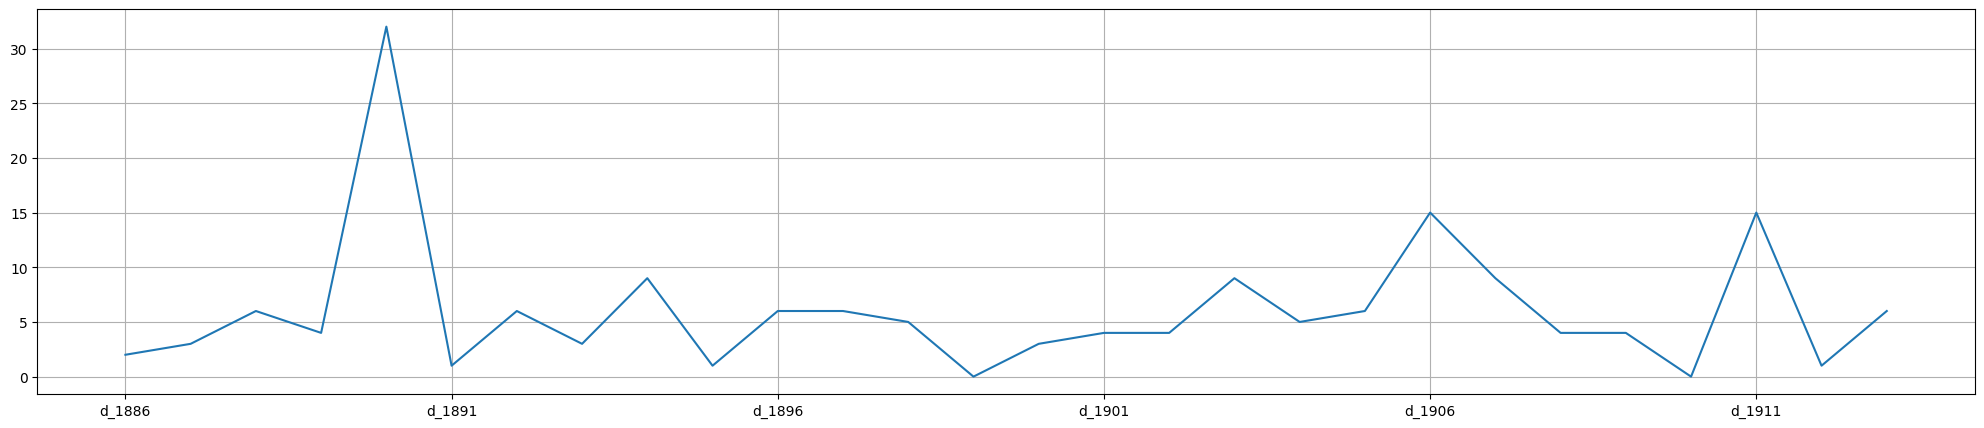

In [ ]:
#show last 28days
figsize = (25, 5)
time_series_data.iloc[15, -28:].plot(figsize=figsize)

plt.grid()
#The last 28 days
print(time_series_data.iloc[0, 1885:].shape)

In [ ]:
#scale

def min_max(df):
    return (df-df.mean())/df.std()

<ipython-input-57-e10a63b7f820>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  price_sell = calendar.merge(sale_price[sale_price.item_id=='HOBBIES_1_00'+str(i)][sale_price.store_id=='CA_1'], on = ['wm_yr_wk'], how = 'left')
<ipython-input-57-e10a63b7f820>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  price_sell = calendar.merge(sale_price[sale_price.item_id=='HOBBIES_1_00'+str(i)][sale_price.store_id=='CA_1'], on = ['wm_yr_wk'], how = 'left')
<ipython-input-57-e10a63b7f820>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  price_sell = calendar.merge(sale_price[sale_price.item_id=='HOBBIES_1_00'+str(i)][sale_price.store_id=='CA_1'], on = ['wm_yr_wk'], how = 'left')
<ipython-input-57-e10a63b7f820>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  price_sell = calendar.merge(sale_price[sale_price.item_id=='HOBBIES_1_00'+str(i)][sale_price.store_id=='CA_1'], o

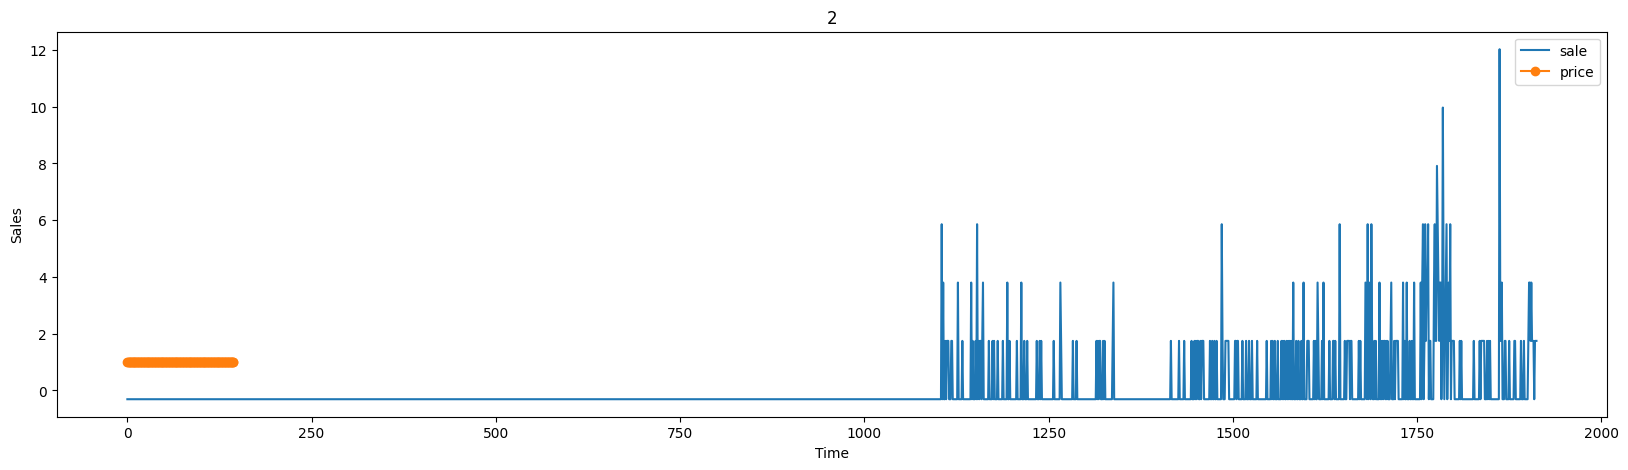

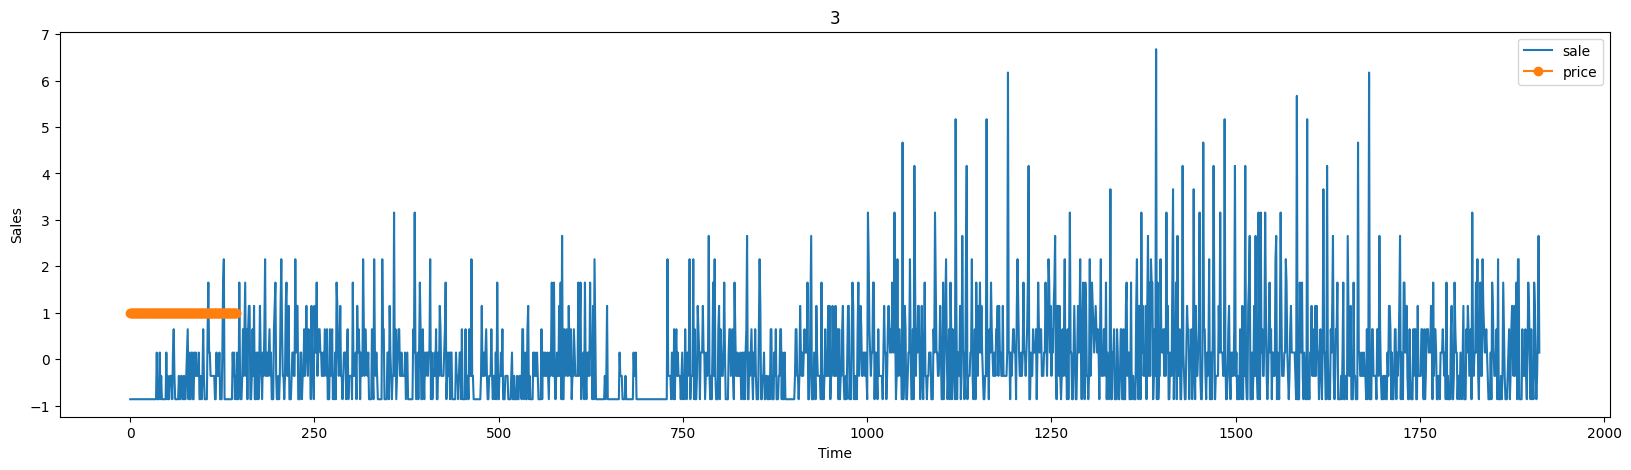

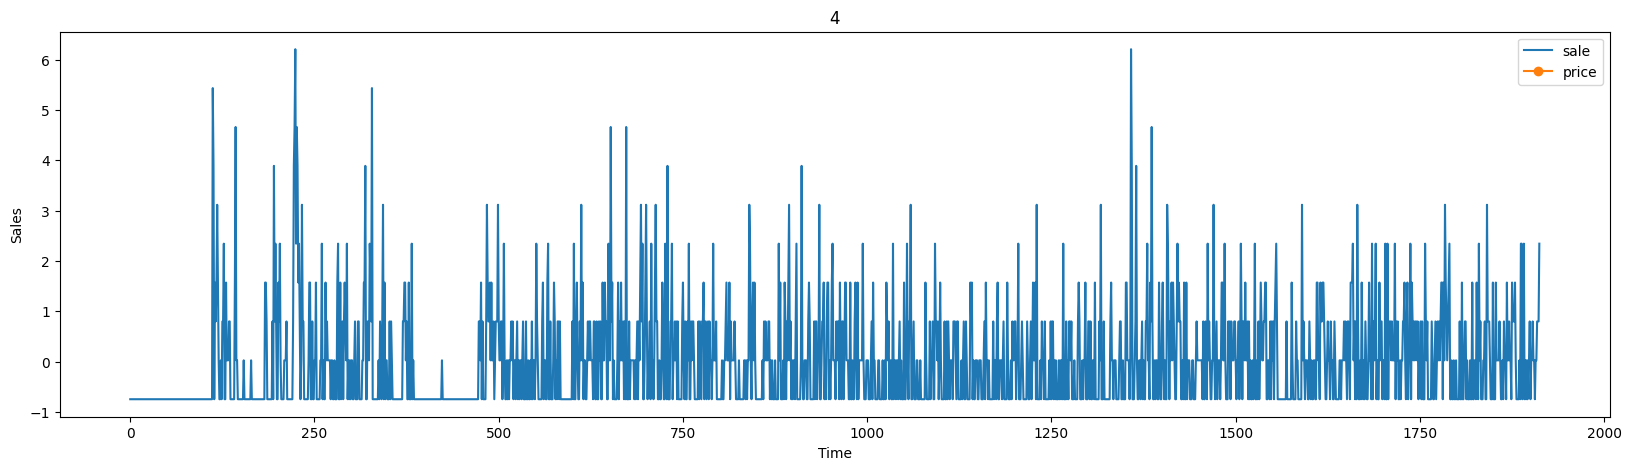

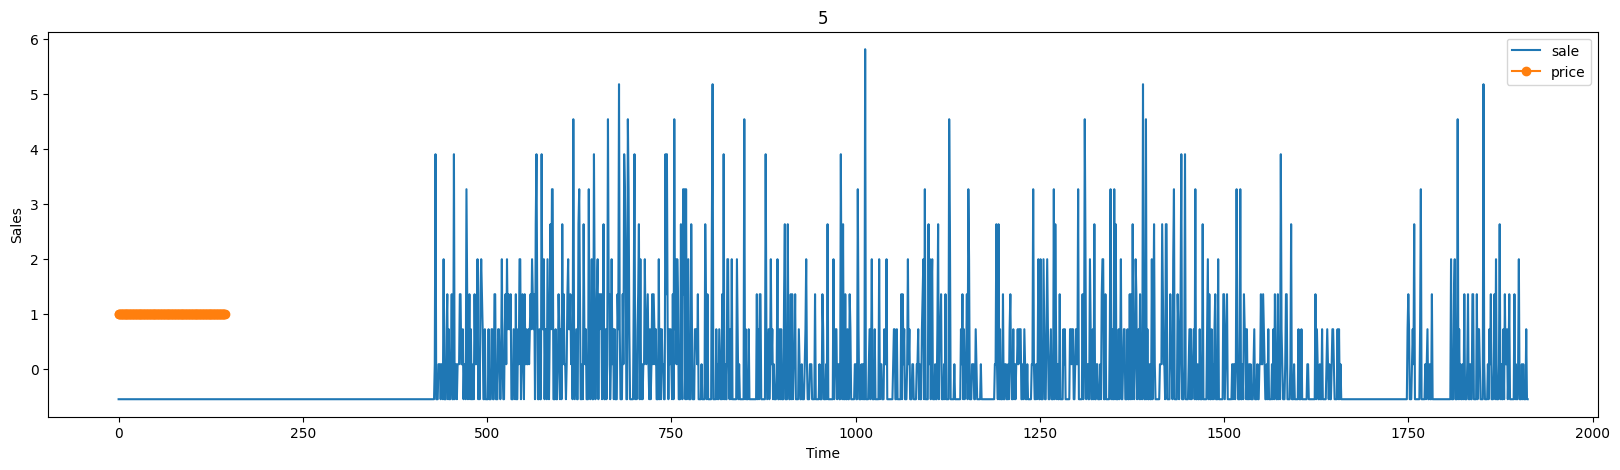

In [ ]:
for i in range(2,6):
    price_sell = calendar.merge(sale_price[sale_price.item_id=='HOBBIES_1_00'+str(i)][sale_price.store_id=='CA_1'], on = ['wm_yr_wk'], how = 'left')

    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(min_max(time_series_data.iloc[i].values))
    ax.plot(min_max(price_sell.sell_price),'-o')
    plt.legend(['sale','price'])
    ax.set_title(str(i))
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

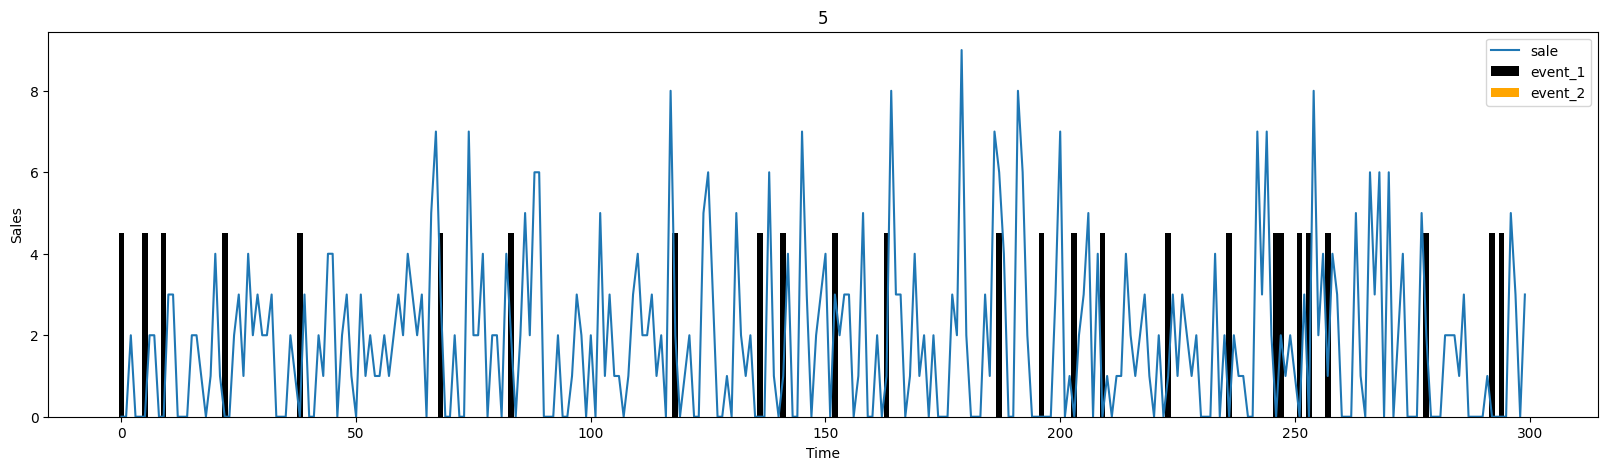

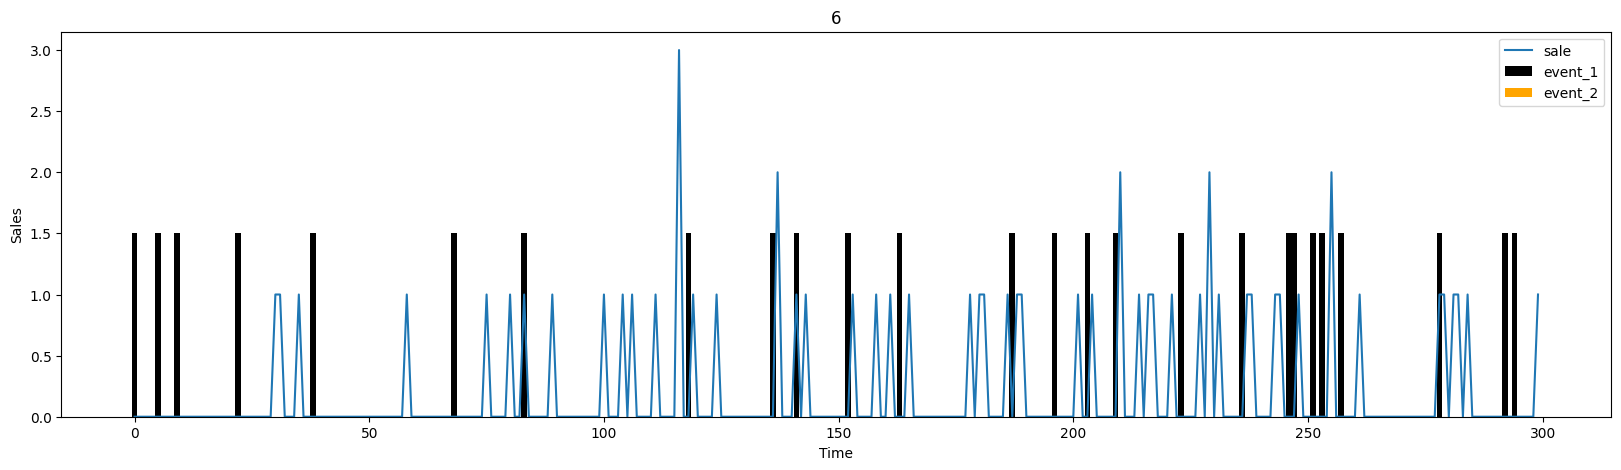

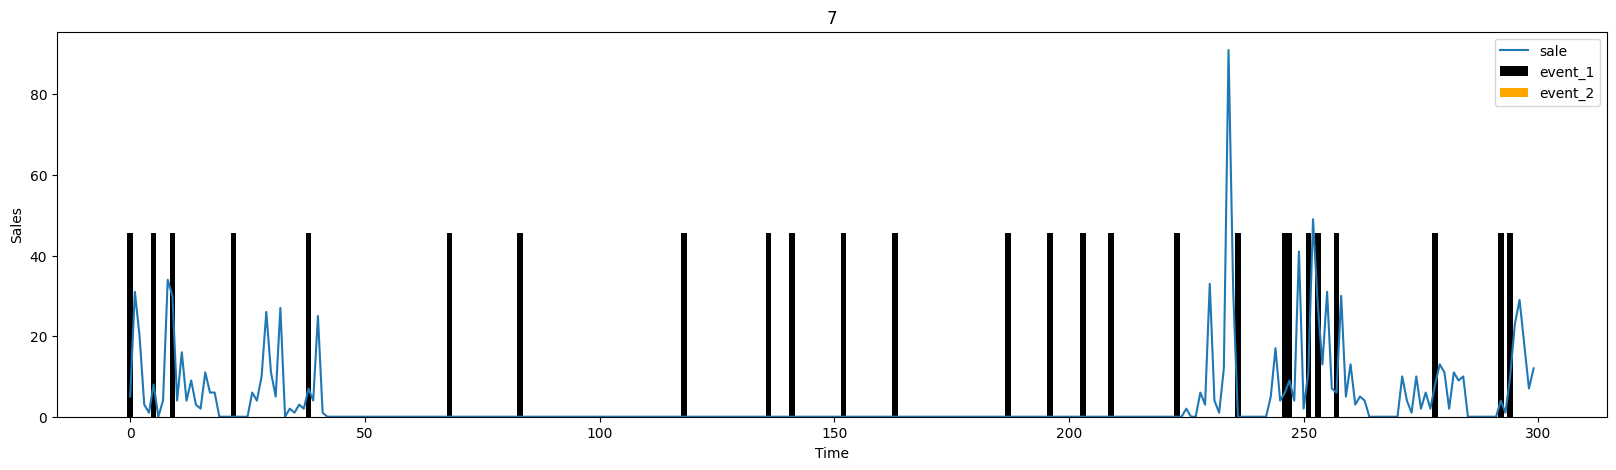

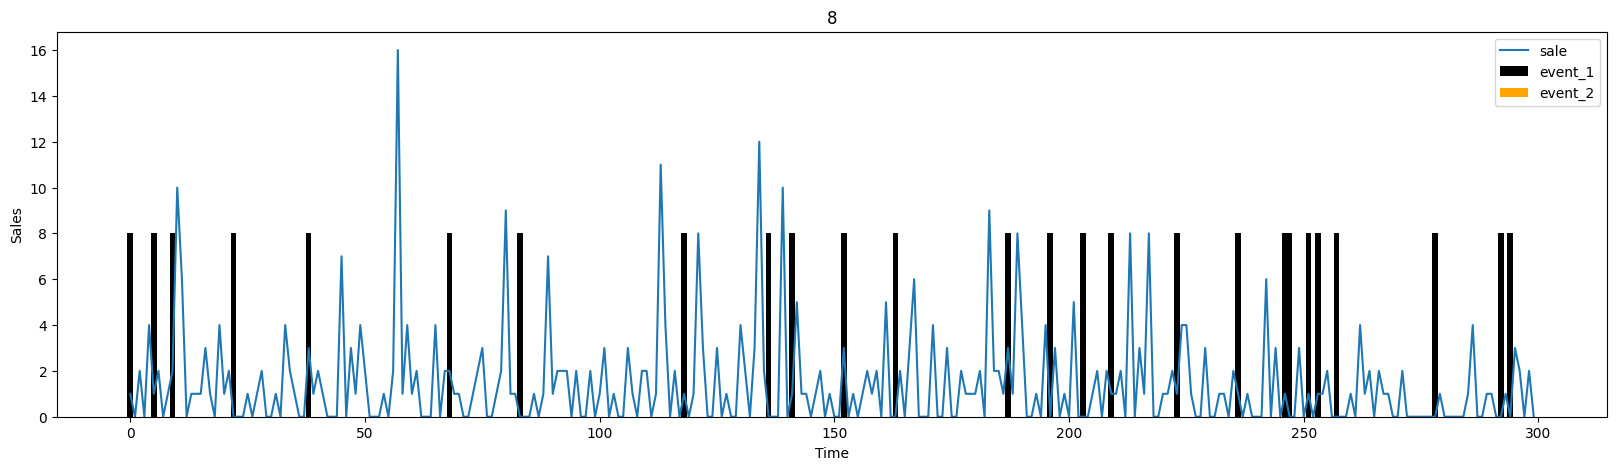

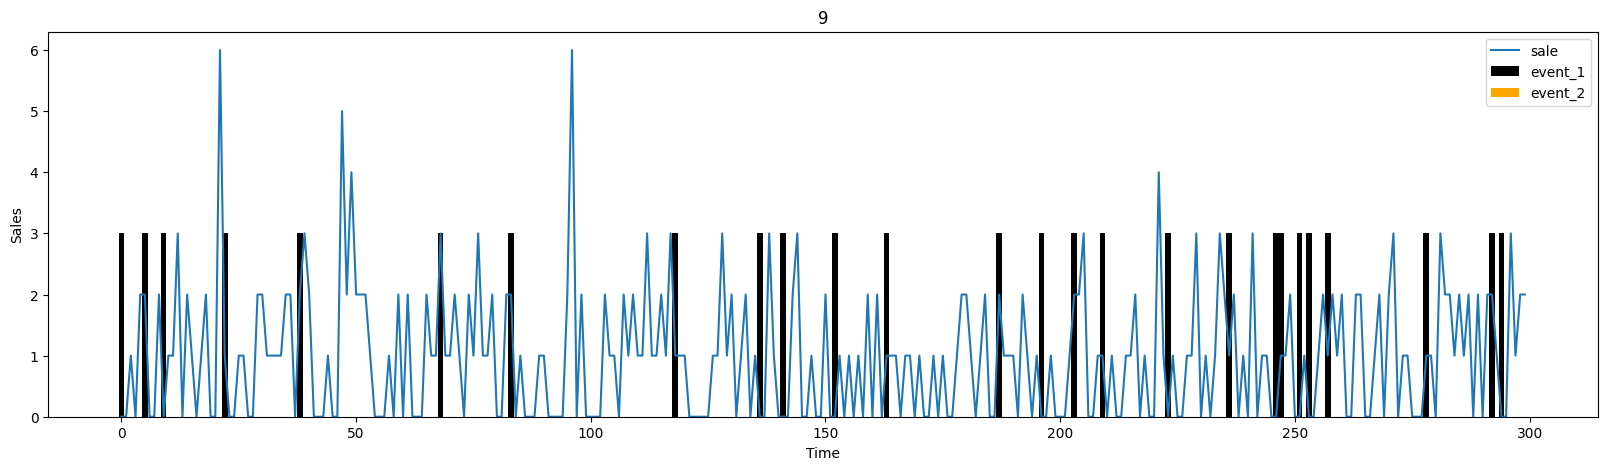

In [ ]:
for i in range(5,10):
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(time_series_data.iloc[i, 500:800].values,label='sales')

    ax.bar(x = range(300),height = event_name_1_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_1',facecolor='black',width=1.2)
    ax.bar(x = range(300),height = event_name_2_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_2',facecolor='orange',width=1.2)
    plt.legend(['sale','event_1','event_2'])
    ax.set_title(str(i))

    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

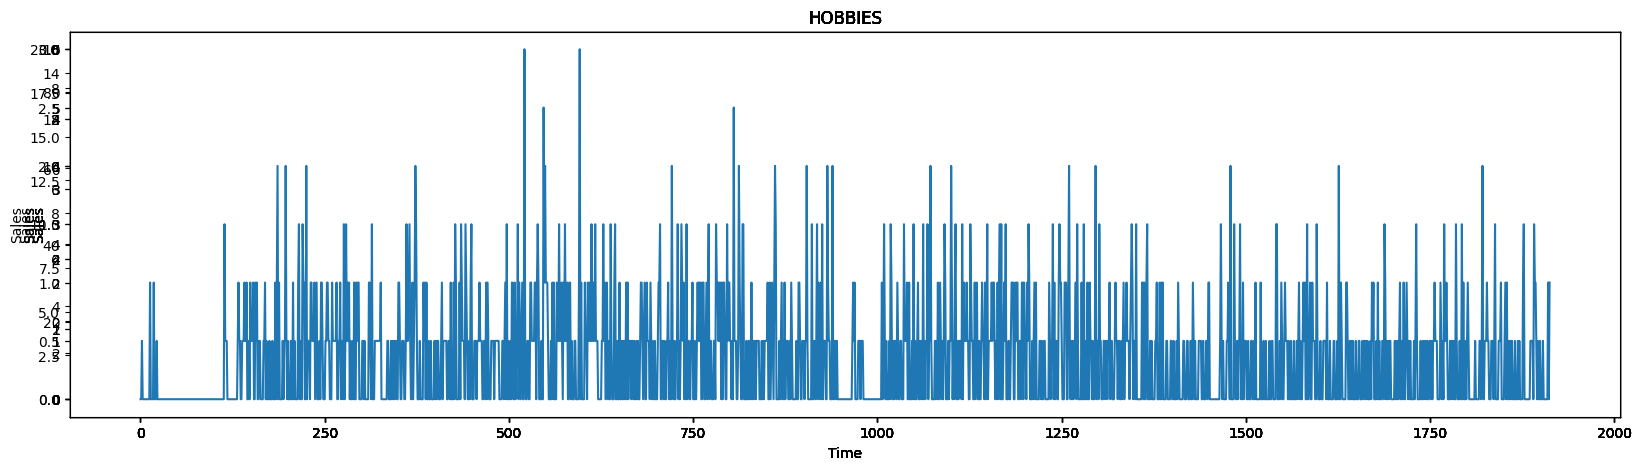

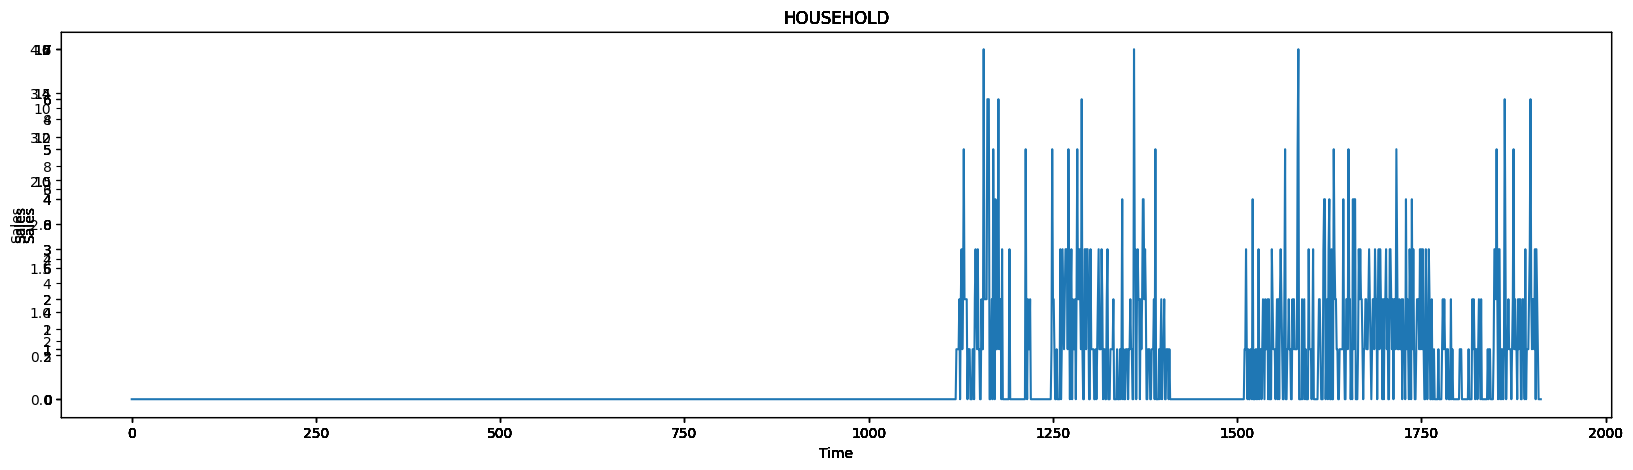

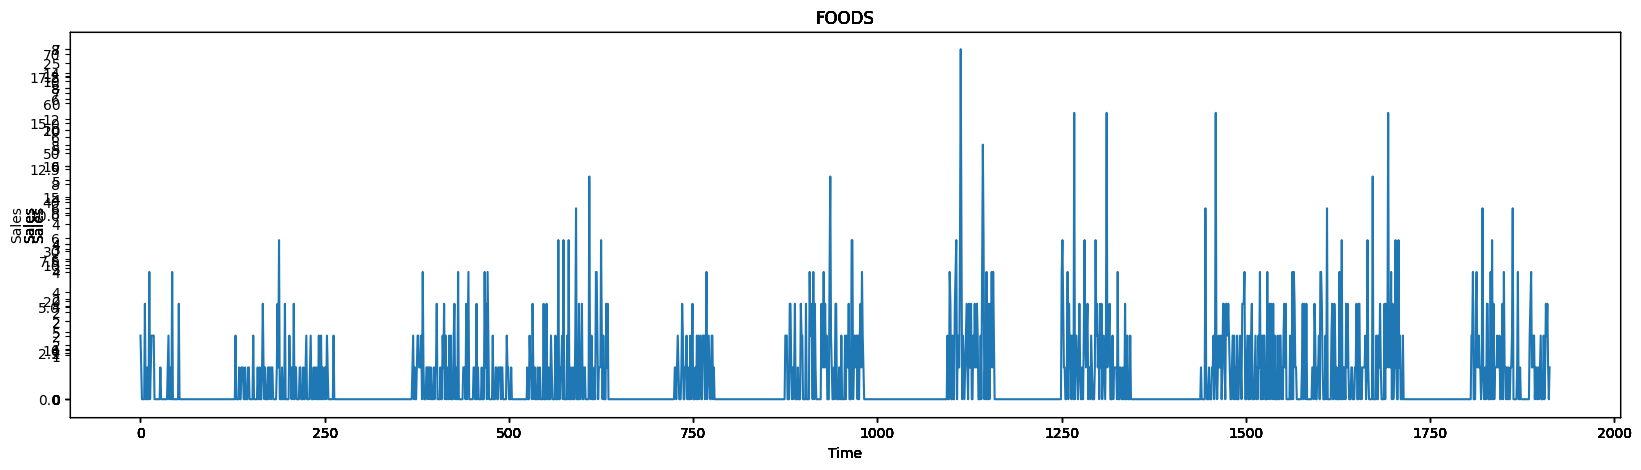

In [ ]:
for i in sales_train.cat_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(sales_train[sales_train.cat_id==i].iloc[j, :][time_series_columns].values)

        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

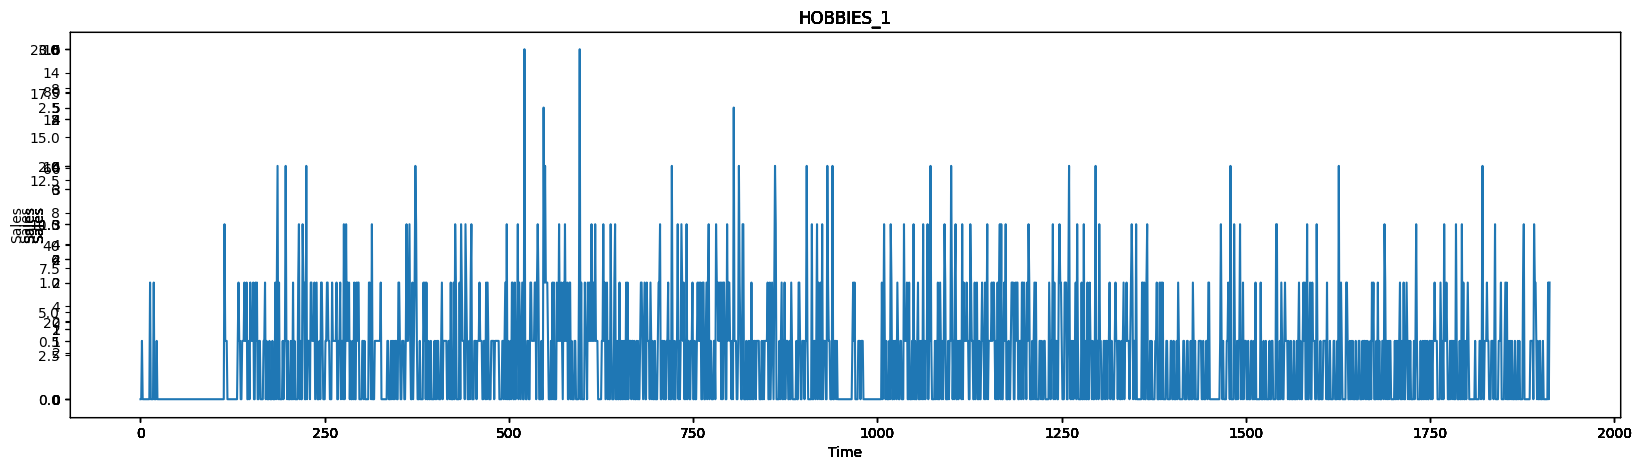

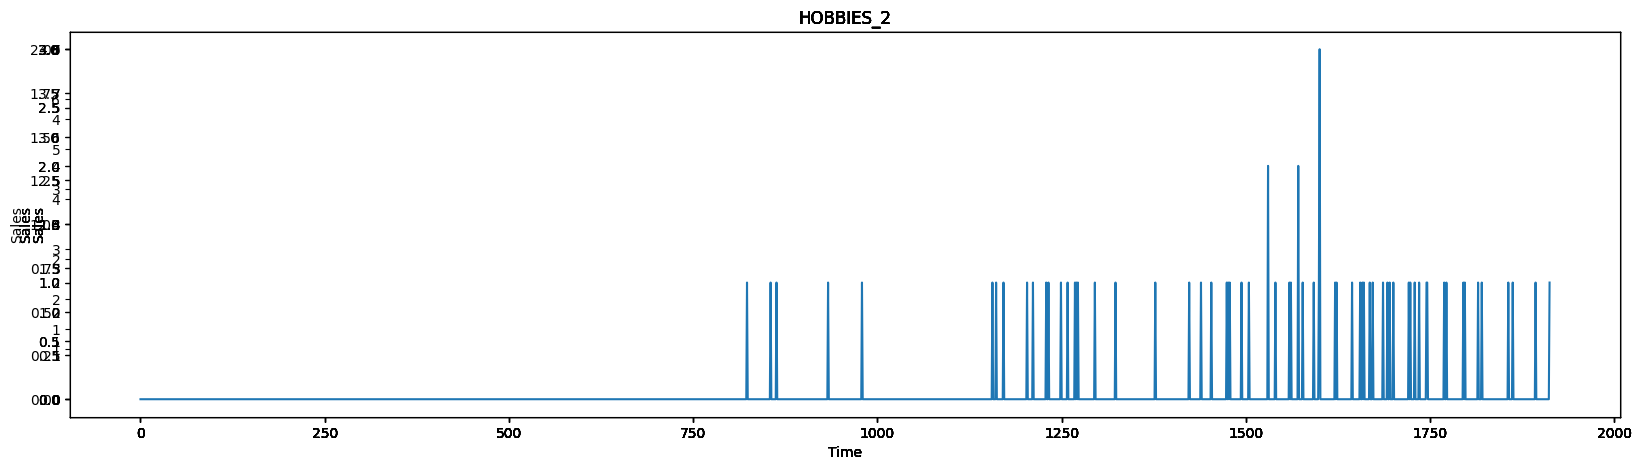

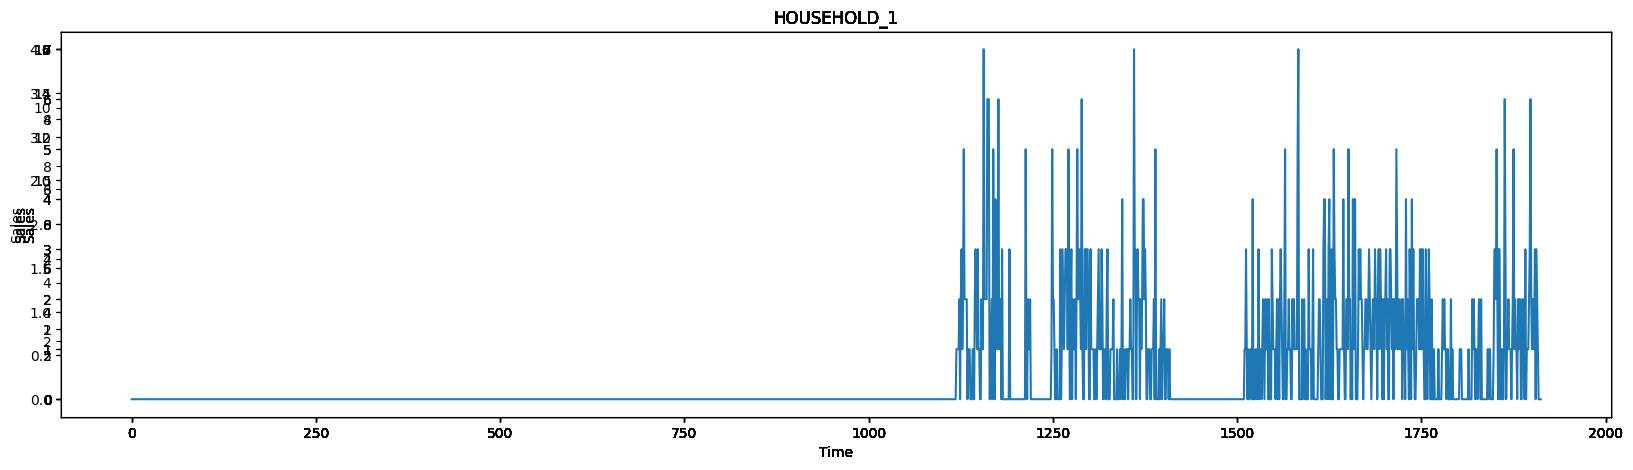

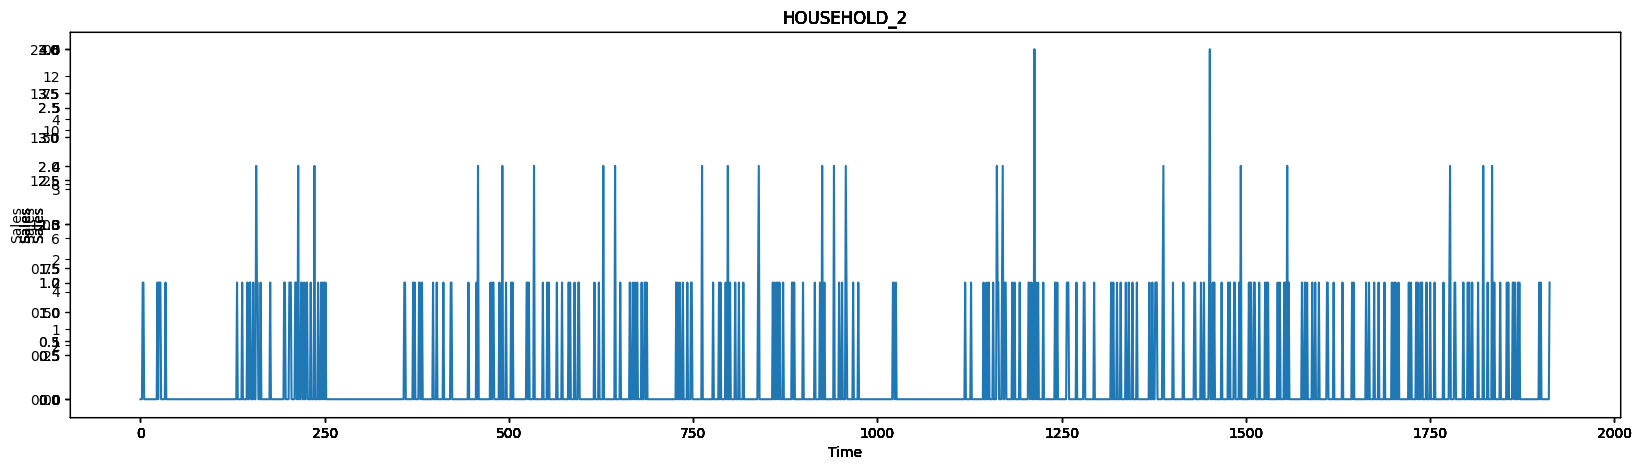

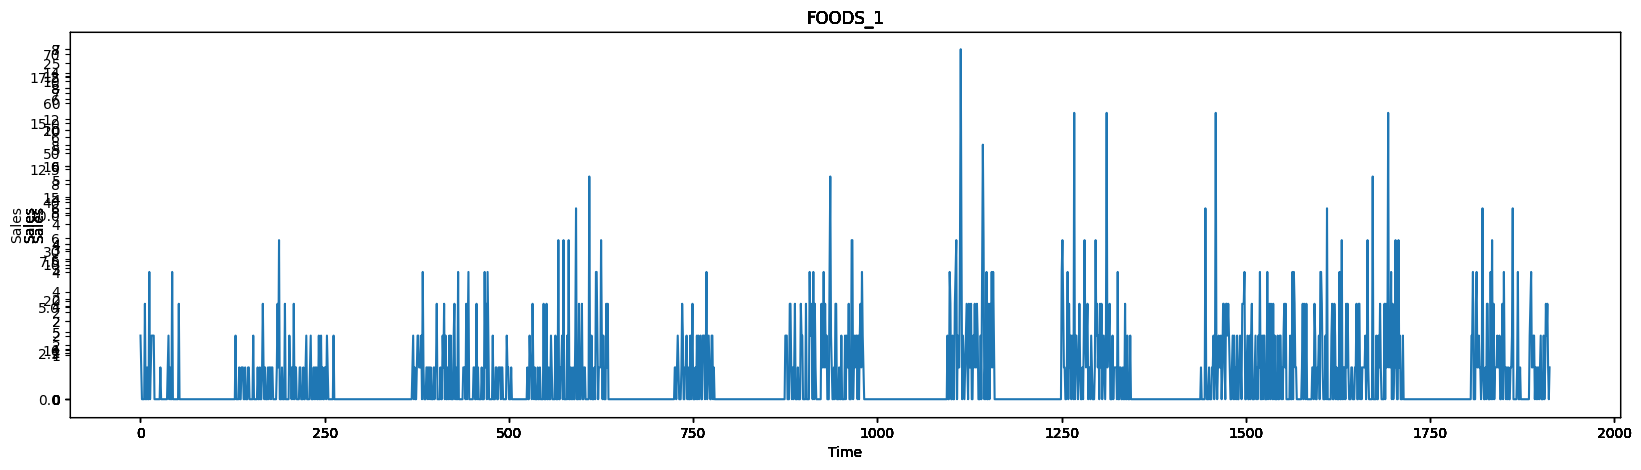

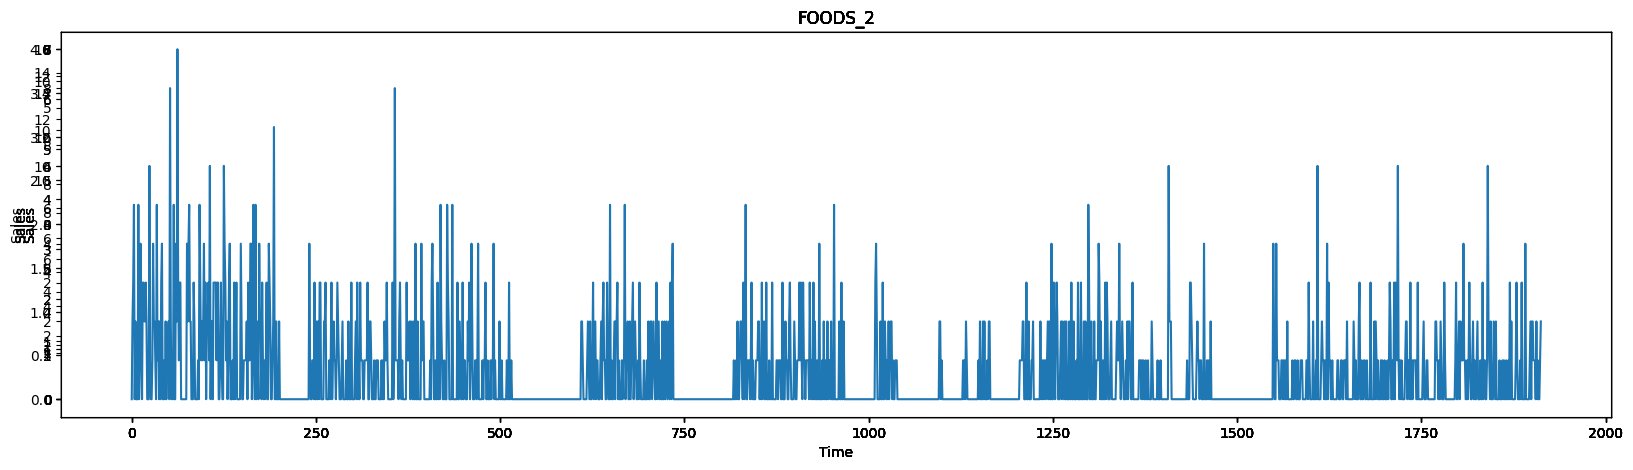

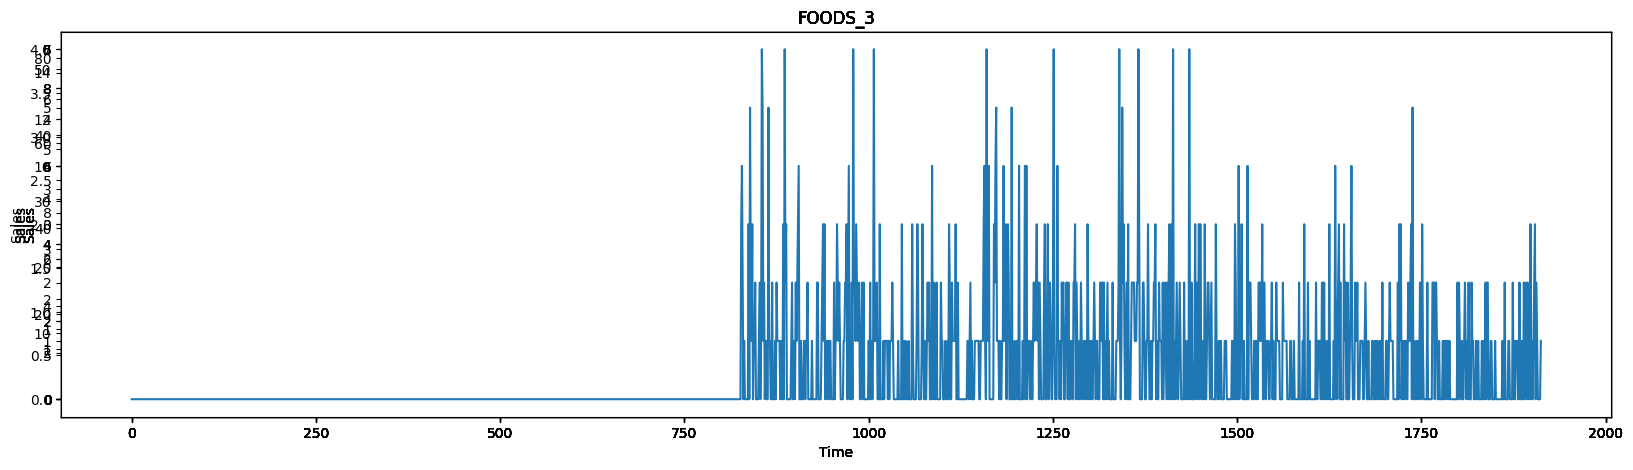

In [ ]:
for i in sales_train.dept_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(sales_train[sales_train.dept_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

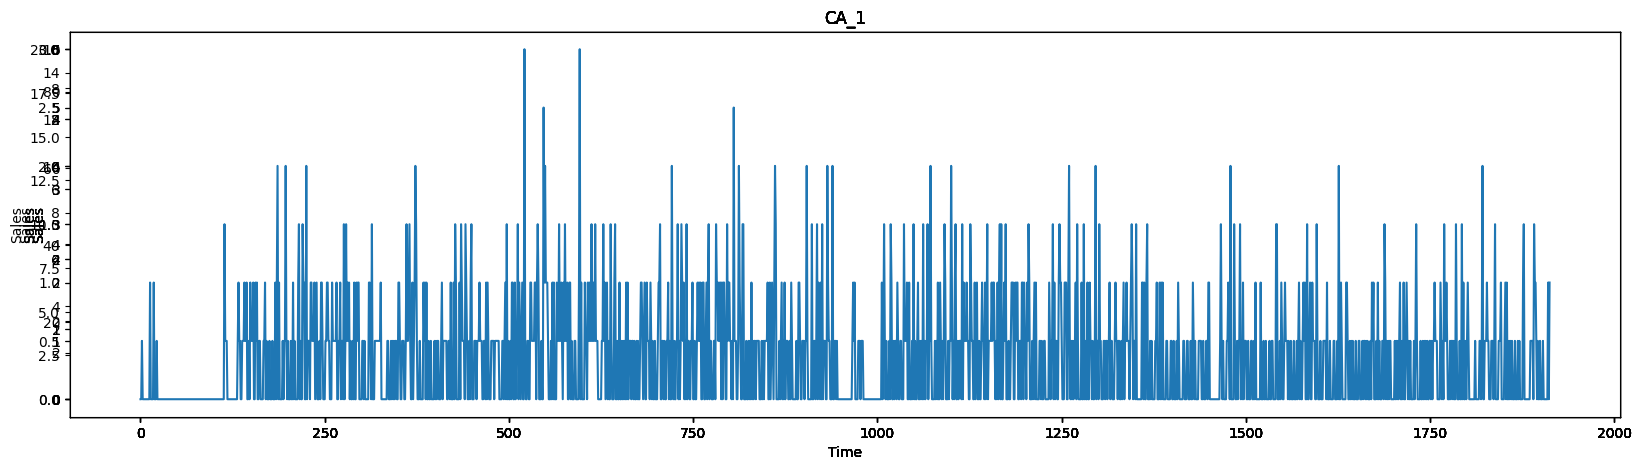

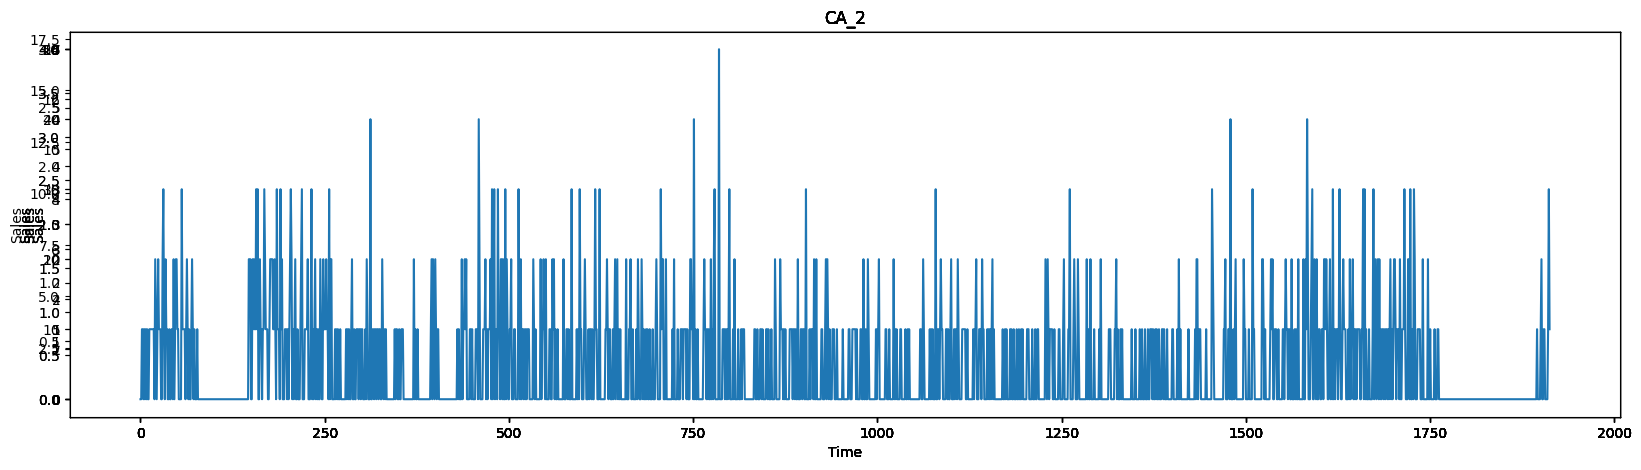

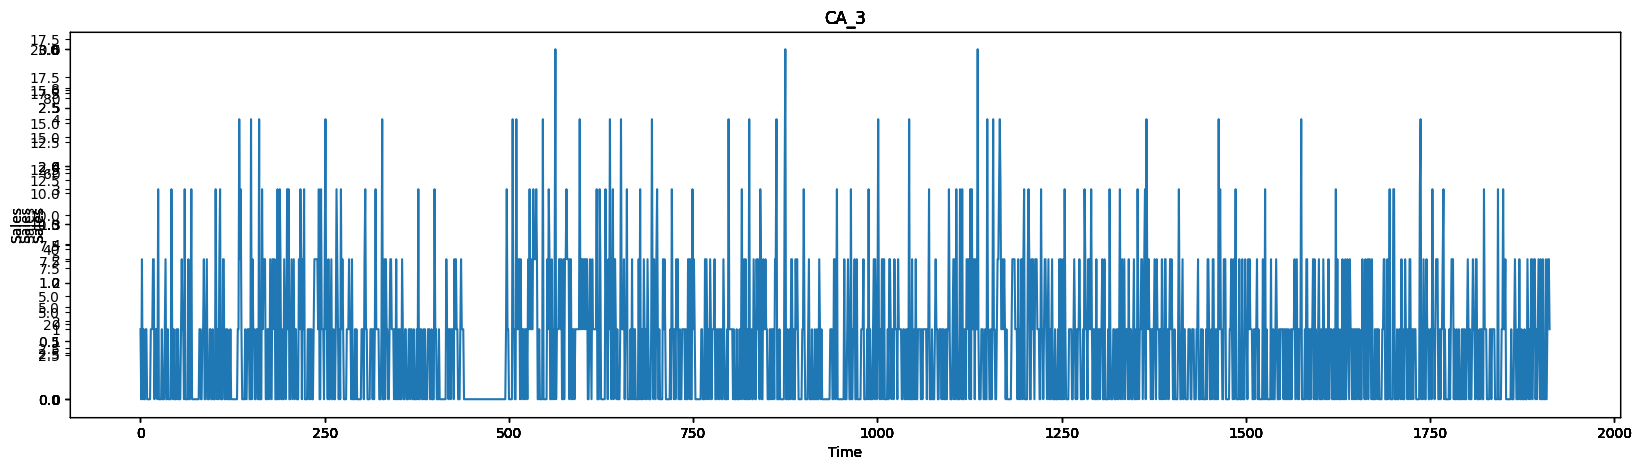

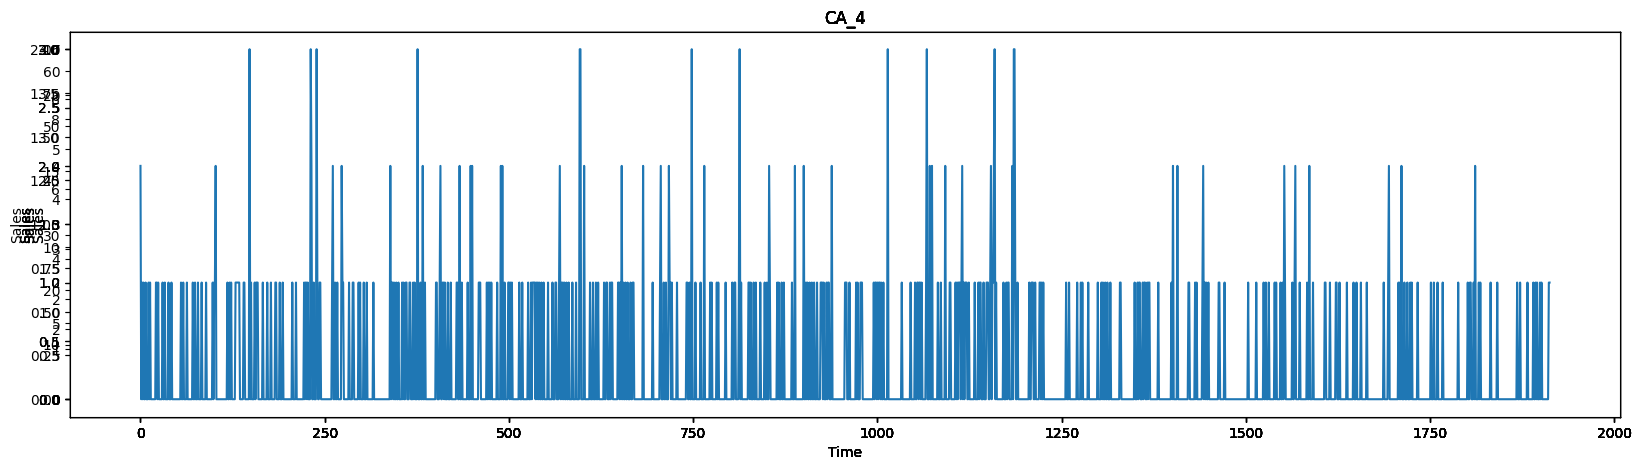

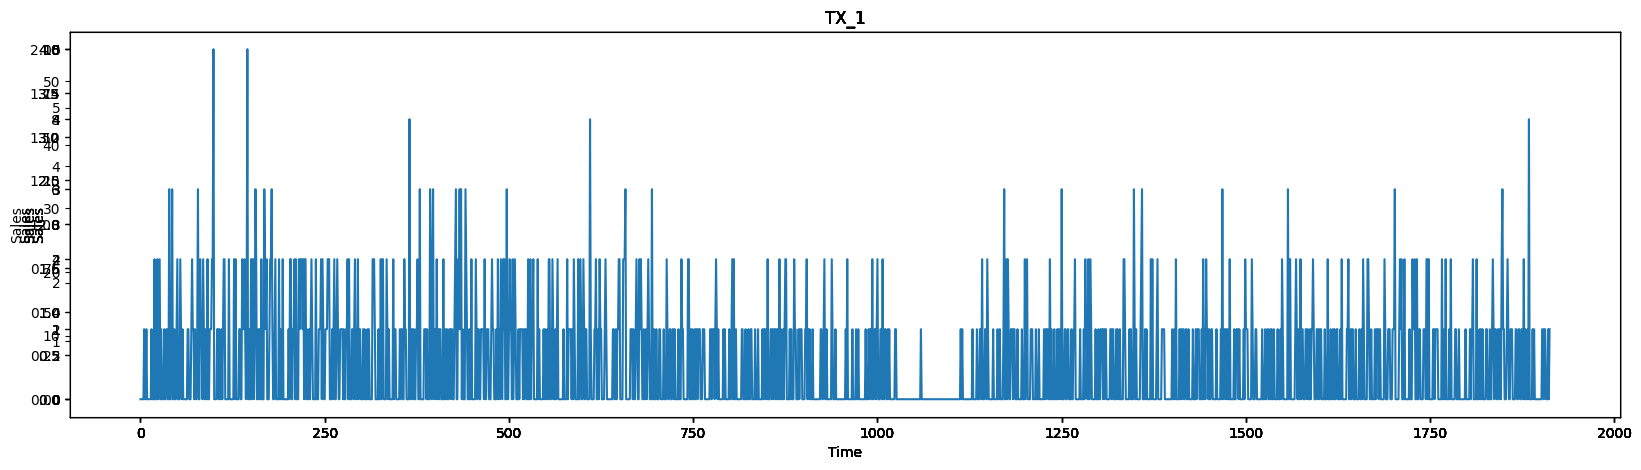

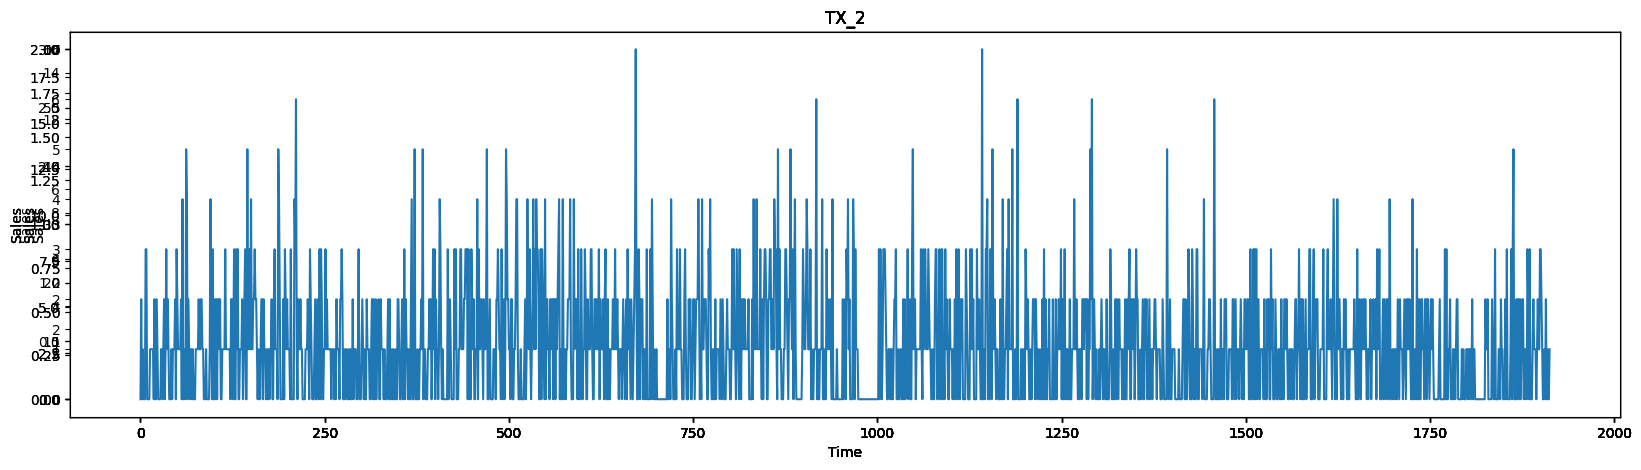

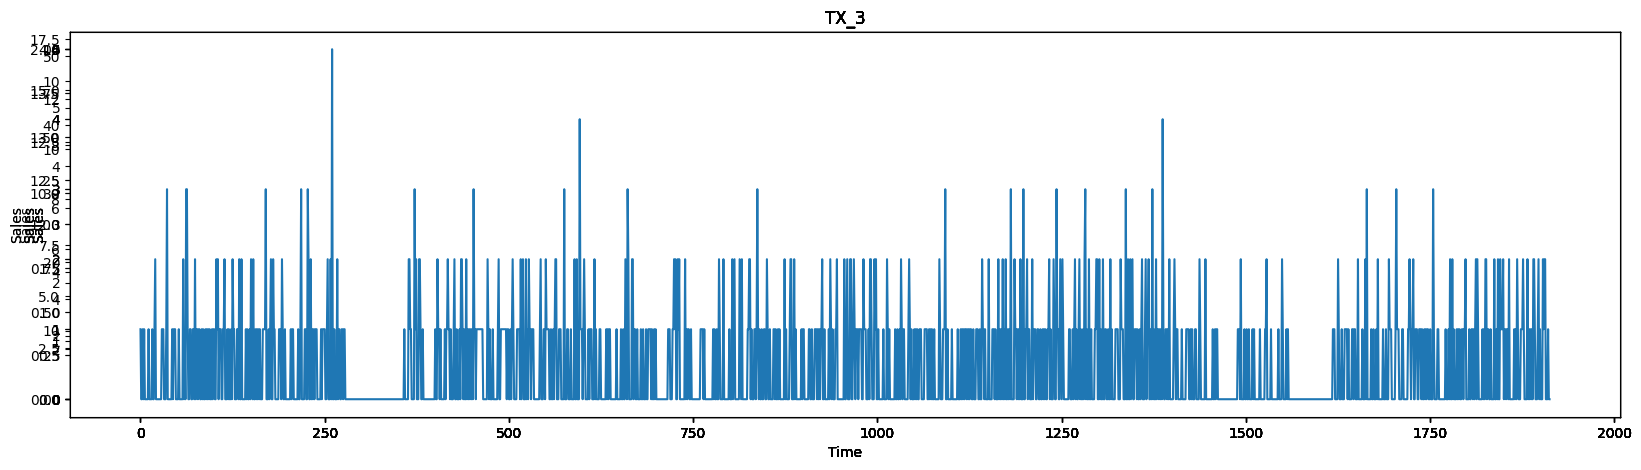

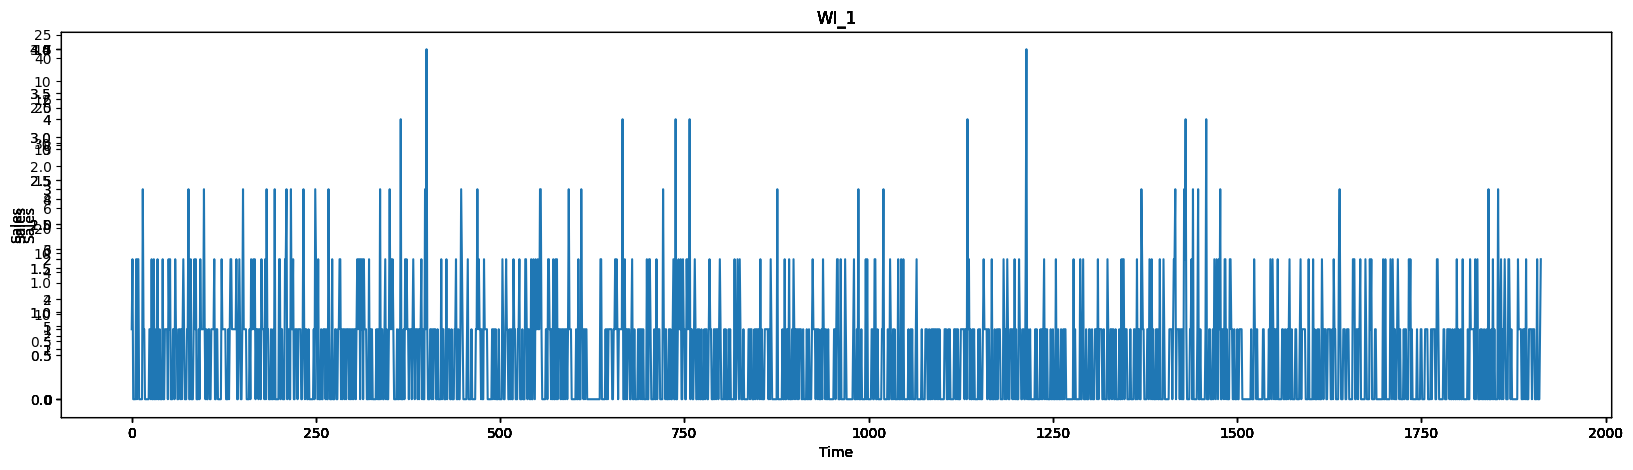

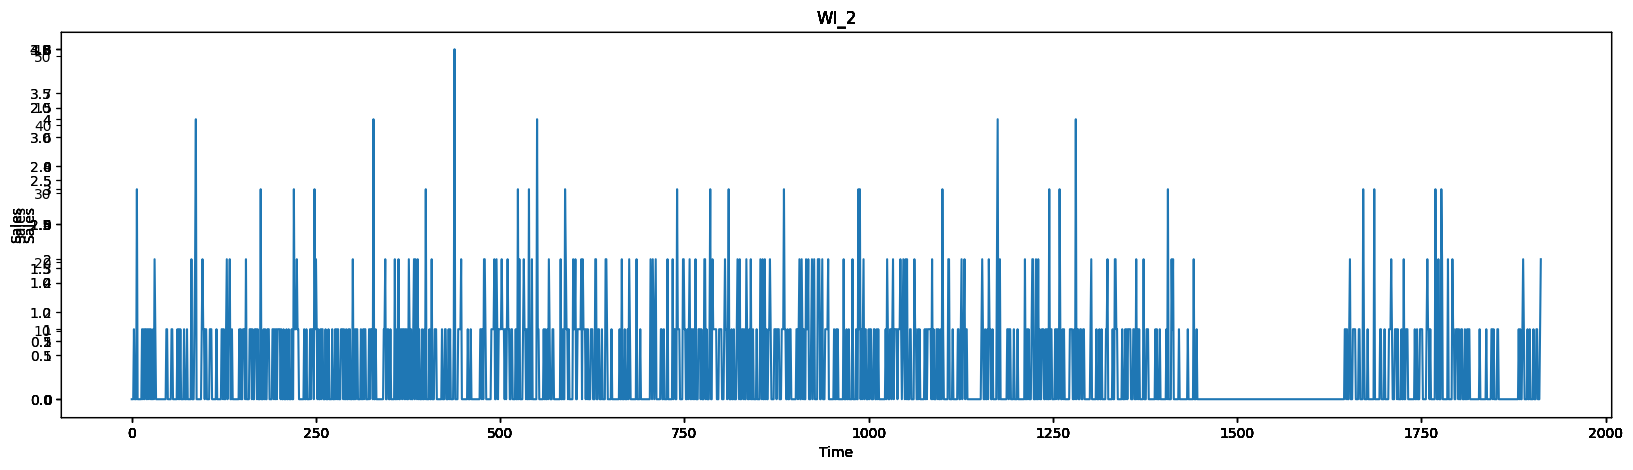

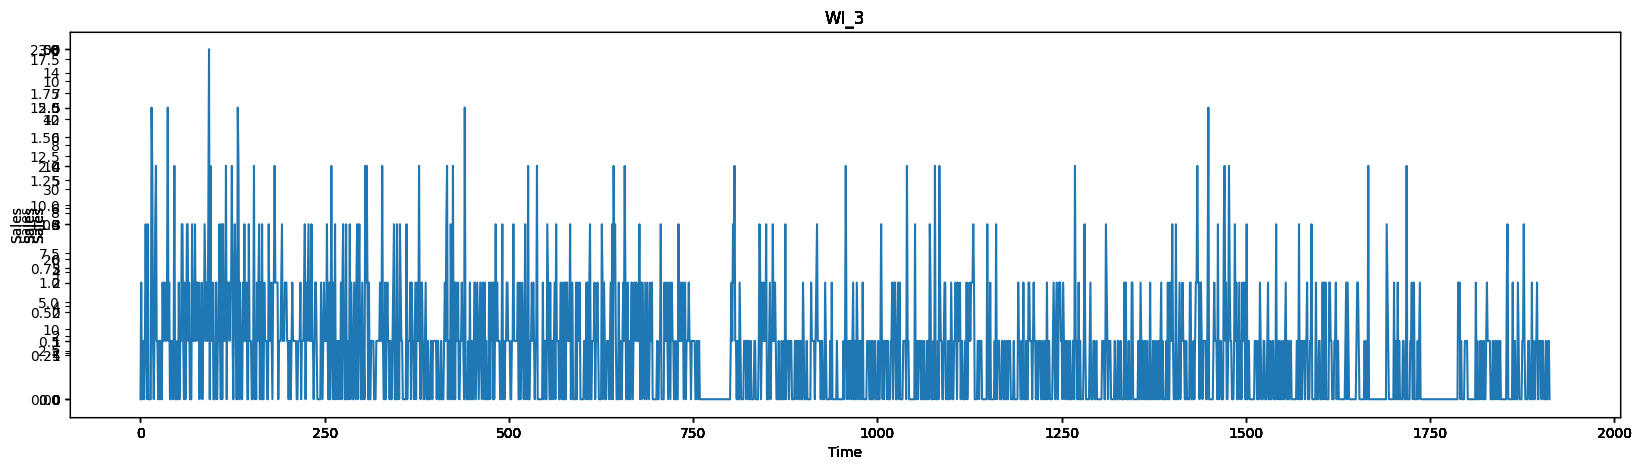

In [ ]:
for i in sales_train.store_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(sales_train[sales_train.store_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

In [ ]:
#build a data with two features(sales and event)
X =[]

for i in tqdm(range(time_series_data.shape[0])):
    X.append([list(t) for t in zip(transfer_cal.loc['event_name_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_type_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_name_2'][-(100+28):-(28)],
                                   transfer_cal.loc['event_type_2'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_CA'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_TX'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_WI'][-(100+28):-(28)],
                                   price_df.iloc[i][-(100+28):-(28)],
                                   time_series_data.iloc[i][-100:])])

100%|██████████| 30490/30490 [00:31<00:00, 962.79it/s]


In [ ]:
X = np.asarray(X, dtype=np.float32)

In [ ]:
transfer_cal.loc['event_name_1'][-(100+28):-(28)]

17     16
18     15
19     10
20     16
21      3
       ..
112    16
113    16
114    16
115    16
116    16
Name: event_name_1, Length: 100, dtype: int64

In [ ]:
transfer_cal.head(50)

0    1    2    3    4    5    6    7    8    9    ...  135  136  \
event_name_1   16   16   16   16   16   16   16   16   16   16  ...   16   16   
event_type_1    4    4    4    4    4    4    4    4    4    4  ...    4    4   
event_name_2    1    1    1    1    1    1    1    1    1    1  ...    1    1   
event_type_2    1    1    1    1    1    1    1    1    1    1  ...    1    1   
snap_CA         0    0    0    0    0    1    1    1    1    1  ...    1    0   
snap_TX         0    0    0    0    0    1    0    1    0    1  ...    0    1   
snap_WI         0    0    0    0    0    0    1    1    0    1  ...    0    1   

              137  138  139  140  141  142  143  144  
event_name_1   16   16   16   16   16   16   16    6  
event_type_1    4    4    4    4    4    4    4    3  
event_name_2    1    1    1    1    1    1    1    0  
event_type_2    1    1    1    1    1    1    1    0  
snap_CA         0    0    0    0    0    0    0    0  
snap_TX         1    1    0    1    0    0    0    0  
snap_WI         1    0    1    1    0    0    0    0  

[7 rows x 145 columns]

In [ ]:
def Normalize(list):
    list = np.array(list)

    low, high = np.percentile(list, [0, 100])
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list,low,high


def FNoramlize(list,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = list[i]*delta + low
    return list


def Normalize2(list,low,high):
    list = np.array(list)
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list

In [ ]:
np.random.seed(7)


if __name__ == '__main__':
    n_steps = 28
    train_n,train_low,train_high = Normalize(X[:,-(n_steps*2):,:])

    # X_train = train_n[:,-28*2:-28,:]  ## I only use the last 56 days for train_data.
    X_train = train_n[:, :-28, :] #Using all data

    y = train_n[:,-28:,8]
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 9
    n_out_seq_length =28
    num_y = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    print(X_train.shape)
    print(y.shape)




(30490, 28, 9)
(30490, 28, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21343, 28, 9)
(9147, 28, 9)
(21343, 28, 1)
(9147, 28, 1)


### New

In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras import backend as K


In [ ]:
def create_model(lstm_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, input_shape=(28, 9), return_sequences=True),
        Dropout(dropout_rate),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error, r_squared])

    return model



def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))


In [ ]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential([
            LSTM(
                units=hp.Int('units', min_value=50, max_value=300, step=50),
                input_shape=self.input_shape,
                return_sequences=True,
                dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
            ),
            TimeDistributed(Dense(1))
        ])
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='mse',
            metrics=['mae', 'mse', root_mean_squared_error, r_squared]
        )
        return model


In [ ]:
hypermodel = LSTMHyperModel(input_shape=(28, 9))

In [ ]:
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_optimization'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Trial 10 Complete [00h 01m 45s]
val_loss: 8.957024328992702e-05

Best val_loss So Far: 8.800611976766959e-05
Total elapsed time: 01h 10m 11s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
534/534 [==============================] - 6s 7ms/step - loss: 1.6472e-04 - mae: 0.0061 - mse: 1.6472e-04 - root_mean_squared_error: 0.0104 - r_squared: -0.5096 - val_loss: 8.9978e-05 - val_mae: 0.0050 - val_mse: 8.9978e-05 - val_root_mean_squared_error: 0.0086 - val_r_squared: 0.3934
Epoch 2/100
534/534 [==============================] - 3s 6ms/step - loss: 1.1648e-04 - mae: 0.0054 - mse: 1.1648e-04 - root_mean_squared_error: 0.0097 - r_squared: 0.2455 - val_loss: 1.0274e-04 - val_mae: 0.0057 - val_mse: 1.0274e-04 - val_root_mean_squared_error: 0.0091 - val_r_squared: 0.3257
Epoch 3/100
534/534 [==============================] - 4s 7ms/step - loss: 1.1427e-04 - mae: 0.0054 - mse: 1.1427e-04 - root_mean_squared_error: 0.0097 - r_squared: 0.2516 - val_loss: 9.5291e-05 - val_mae: 0.0046 - val_mse: 9.5291e-05 - val_root_mean_squared_error: 0.0089 - val_r_squared: 0.3509
Epoch 4/100
534/534 [==============================] - 4s 8ms/step - loss: 1.1530e-04 - mae: 0.0054 - mse: 1

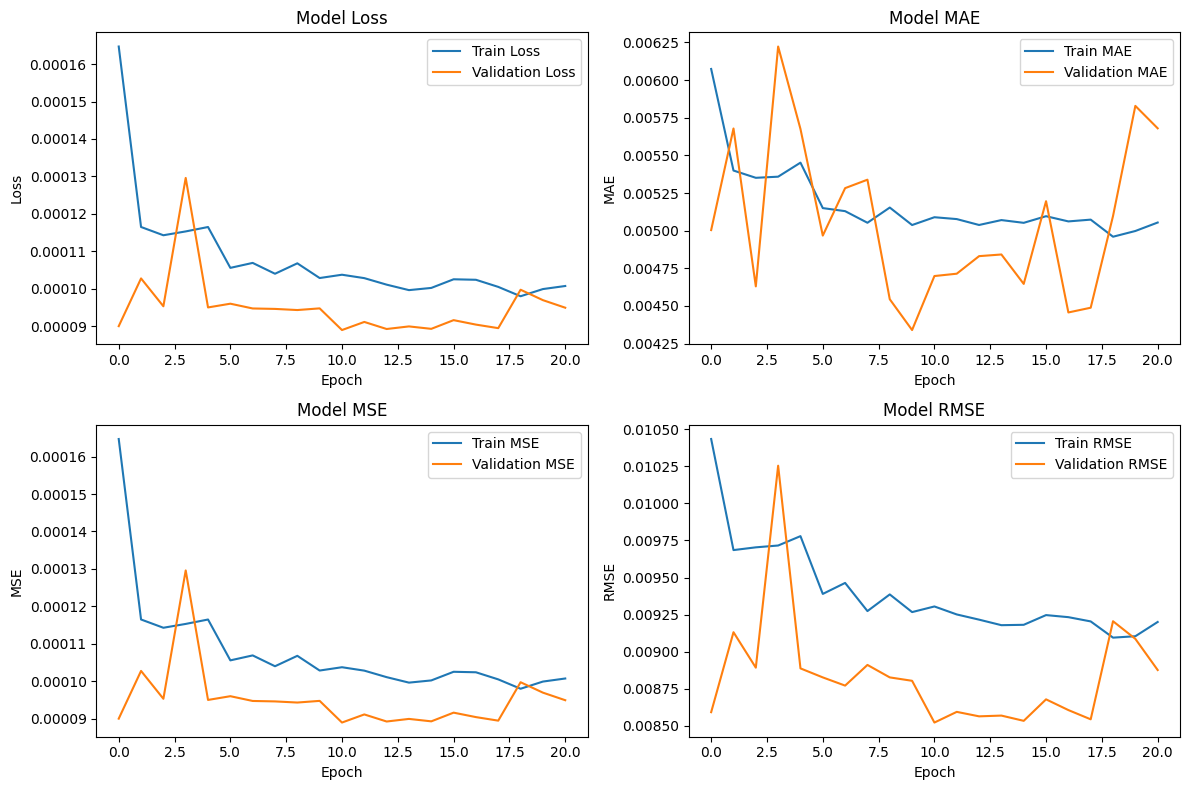

In [ ]:
# Plot for Loss
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot for MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# Plot for MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

# Plot for RMSE
plt.subplot(2, 2, 4)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


286/286 [==============================] - 1s 2ms/step


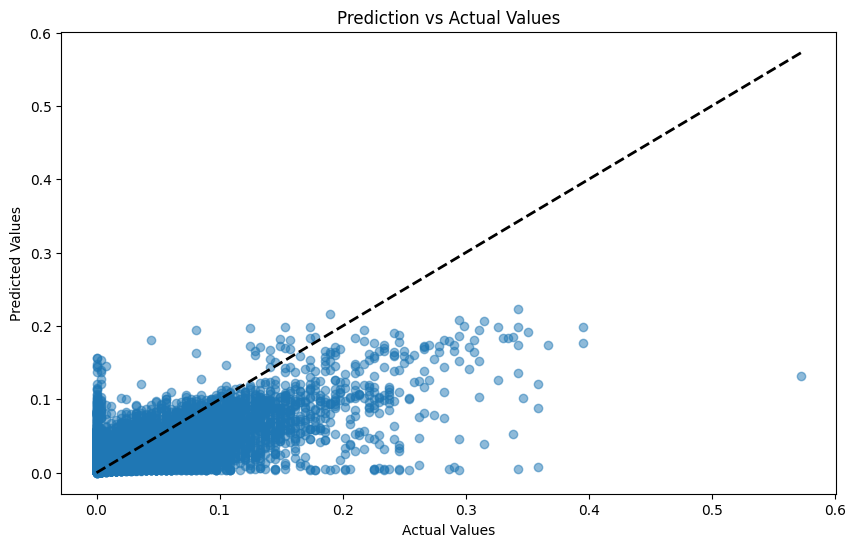

In [ ]:
# Assuming y_test are your true values and predictions are made using the model.predict method on X_test
predictions = model.predict(X_test)

# Flatten the predictions and actual values for easier plotting if they're in multi-dimensional shapes
predictions = predictions.flatten()
y_test_flattened = y_test.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_flattened, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual Values')
# Optional: plot a diagonal line representing perfect predictions
plt.plot([y_test_flattened.min(), y_test_flattened.max()], [y_test_flattened.min(), y_test_flattened.max()], 'k--', lw=2)
plt.show()


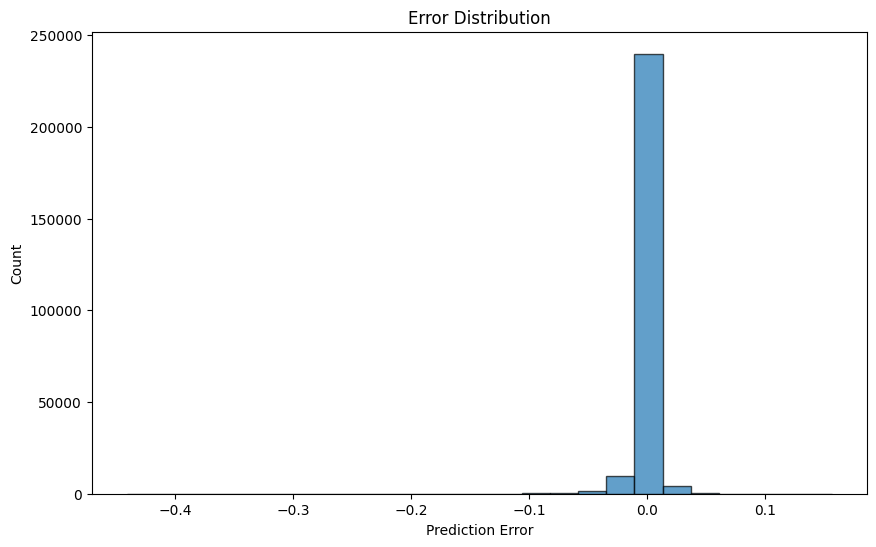

In [ ]:
# Calculate errors
errors = predictions - y_test_flattened

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.show()


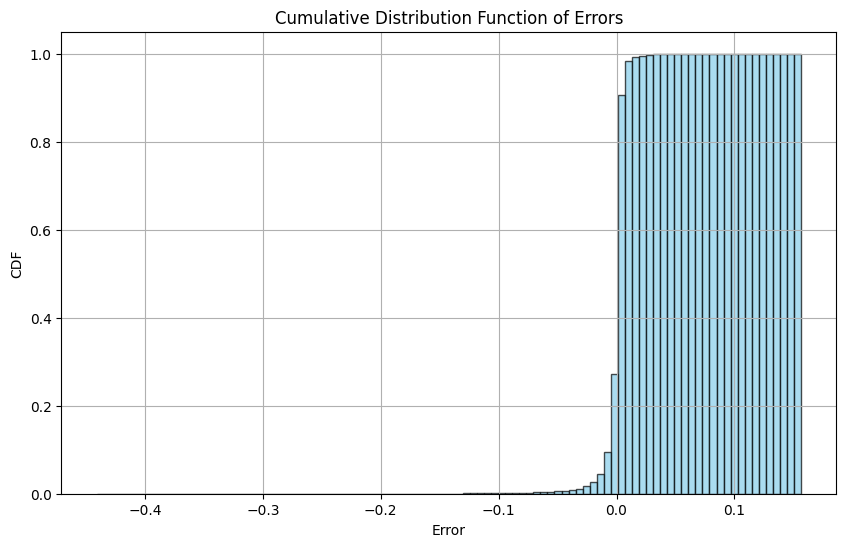

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=100, cumulative=True, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Error')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Errors')
plt.grid(True)
plt.show()


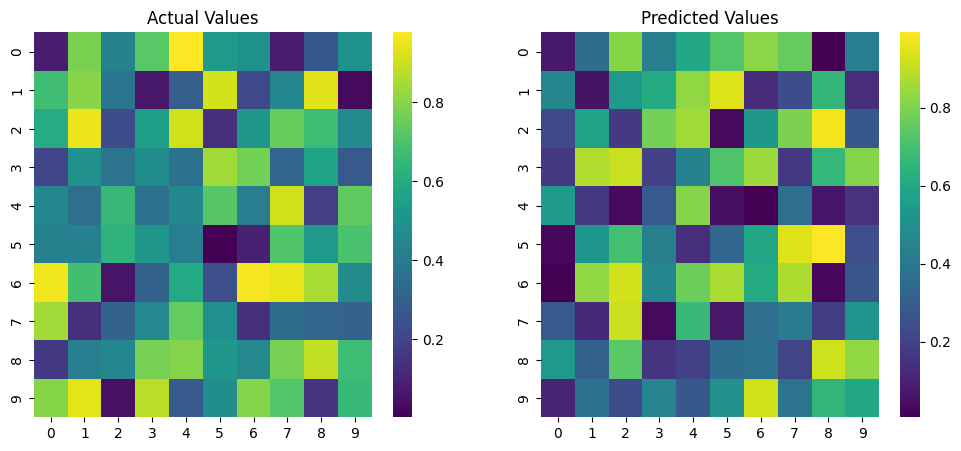

In [ ]:
import seaborn as sns


actual = np.random.rand(10, 10)  # Replace with actual reshaped values
predicted = np.random.rand(10, 10)  # Replace with predicted reshaped values

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(actual, ax=ax[0], cmap='viridis')
ax[0].set_title('Actual Values')
sns.heatmap(predicted, ax=ax[1], cmap='viridis')
ax[1].set_title('Predicted Values')
plt.show()


### Old

In [ ]:
import keras
from keras import metrics

# define model
def train_model(X_train, y_train):

  model = keras.Sequential([
      keras.layers.LSTM(128, activation='softplus', input_shape=(28, n_features),return_sequences=False),
      keras.layers.RepeatVector(n_out_seq_length),
      keras.layers.LSTM(64, activation='softplus',return_sequences=True),
      #keras.layers.LSTM(Dropout(0.1)),
      keras.layers.LSTM(32, activation='softplus',return_sequences=True),
      #keras.layers.LSTM(Dropout(0.1)),
      keras.layers.TimeDistributed(Dense(num_y))
      ])

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[
      #metrics.AUC(),
      'accuracy'
  ])

  # fit model
  history = model.fit(X_train, y_train, epochs=10, batch_size=500, validation_data=(X_test, y_test))

  return model, history


In [ ]:
model, history = train_model(X_train, y_train)

Epoch 1/10
43/43 [==============================] - 33s 660ms/step - loss: 1.4429 - accuracy: 0.5304 - val_loss: 0.0048 - val_accuracy: 0.5663
Epoch 2/10
43/43 [==============================] - 28s 661ms/step - loss: 0.0027 - accuracy: 0.5613 - val_loss: 0.0019 - val_accuracy: 0.5663
Epoch 3/10
43/43 [==============================] - 31s 724ms/step - loss: 0.0017 - accuracy: 0.5613 - val_loss: 0.0014 - val_accuracy: 0.5663
Epoch 4/10
43/43 [==============================] - 27s 624ms/step - loss: 0.0013 - accuracy: 0.5613 - val_loss: 0.0011 - val_accuracy: 0.5663
Epoch 5/10
43/43 [==============================] - 27s 617ms/step - loss: 9.9944e-04 - accuracy: 0.5613 - val_loss: 8.7628e-04 - val_accuracy: 0.5663
Epoch 6/10
43/43 [==============================] - 29s 684ms/step - loss: 8.0974e-04 - accuracy: 0.5613 - val_loss: 7.1594e-04 - val_accuracy: 0.5663
Epoch 7/10
43/43 [==============================] - 32s 745ms/step - loss: 6.7007e-04 - accuracy: 0.5613 - val_loss: 5.9528e-0

In [ ]:
def plot_train_loss_acc(history):
    fig, [ax1, ax2]=plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(history.history['loss'], label='loss')
    ax1.set_xlabel('Epoch')# epoch means training cycle
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

def plot_test_loss_acc(history):
    fig, [ax1, ax2]=plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(history.history['val_loss'], label='loss')
    ax1.set_xlabel('Epoch')# epoch means training cycle
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(history.history['val_accuracy'], label='accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

def plot_auc(history):
    plt.plot(history.history['auc_6'])
    plt.plot(history.history['val_auc_6'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()




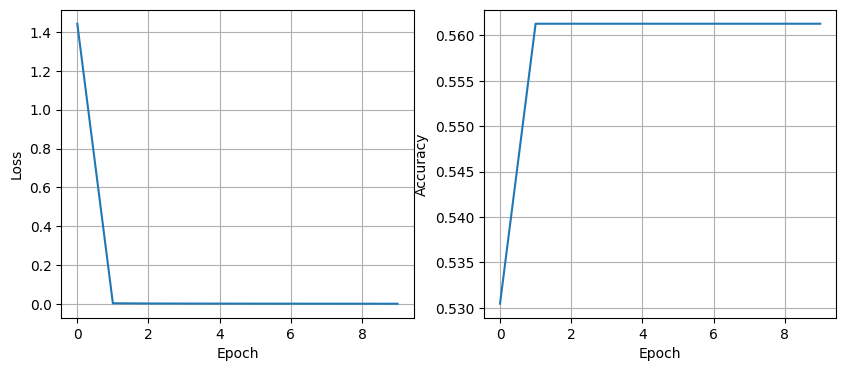

In [ ]:
plot_train_loss_acc(history)

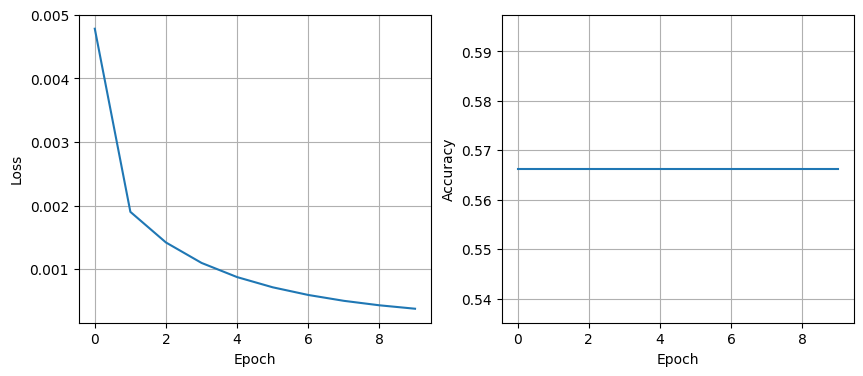

In [ ]:
plot_test_loss_acc(history)

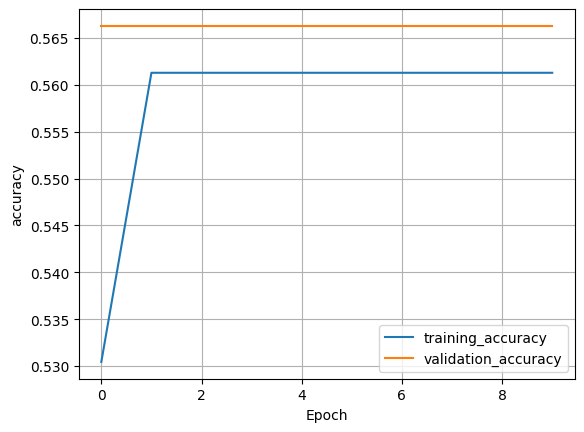

In [ ]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')

plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid(True)

plt.legend()
plt.show()

In [ ]:
train_loss, train_accuracy=model.evaluate(X_train,y_train)

667/667 [==============================] - 24s 35ms/step - loss: 3.9378e-04 - accuracy: 0.5613


In [ ]:
test_loss, test_accuracy=model.evaluate(X_test,y_test)

286/286 [==============================] - 8s 27ms/step - loss: 3.7903e-04 - accuracy: 0.5663


In [ ]:
print(f"Training loss: {train_loss:.8f}")
print(f"Training accuracy: {train_accuracy*100:.3f}")
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy*100:.3f}")

Training loss: 0.00039378
Training accuracy: 56.128
Test loss: 0.00037903
Test accuracy: 56.628


In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasRegressor

In [ ]:
y_train = y_train.reshape(-1, n_out_seq_length)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

from keras import metrics  # Import metrics from keras

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error  # Import mean_squared_error for loss calculation
from sklearn.metrics import accuracy_score
import numpy as np

# Define a function to create the model
def create_model():
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(28, n_features), return_sequences=False))
    model.add(RepeatVector(n_out_seq_length))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(num_y)))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[
        metrics.AUC(),  # Import AUC from keras.metrics
        'accuracy'  # Use 'accuracy' as a string for accuracy metric
    ])
    return model

# Create a custom wrapper function to match the Scikit-learn estimator interface
def build_model():
    return KerasRegressor(build_fn=create_model, epochs=20, batch_size=500, verbose=0)

# Define the scoring function
def custom_scoring(y_true, y_pred):
    return -np.mean((y_true - y_pred)**2)

# Wrap the scoring function
mse_scorer = make_scorer(custom_scoring, greater_is_better=False)

# Define the grid search parameters
param_grid = {'batch_size': [100, 500, 1000],
              'epochs': [10, 20, 30]}

# Create and fit the grid search
grid = GridSearchCV(estimator=build_model(), param_grid=param_grid, scoring=mse_scorer, n_jobs=-1, error_score='raise')
grid_result = grid.fit(X_train, y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:

def tr_mod(X_train,y_train, X_test,y_test):

  model1 = Sequential()
  model1.add(LSTM(128, activation='tanh', input_shape=(28, n_features), return_sequences=False))
  model1.add(RepeatVector(n_out_seq_length))
  model1.add(LSTM(32, activation='tanh', return_sequences=True))
  model1.add(TimeDistributed(Dense(num_y)))
  model1.compile(optimizer='adam', loss='mean_squared_error', metrics=[
      #metrics.AUC(),  # Import AUC from keras.metrics
      'accuracy'  # Use 'accuracy' as a string for accuracy metric
  ])
  # fit model
  history1 = model1.fit(X_train, y_train, epochs=30, batch_size=500, validation_data=(X_test,y_test))

  return model1, history1

In [ ]:
model1, history1 = tr_mod(X_train,y_train, X_test,y_test)

Epoch 1/30
43/43 [==============================] - 21s 382ms/step - loss: 1.4232e-04 - accuracy: 0.5613 - val_loss: 8.0524e-05 - val_accuracy: 0.5663
Epoch 2/30
43/43 [==============================] - 19s 443ms/step - loss: 8.2863e-05 - accuracy: 0.5613 - val_loss: 7.7244e-05 - val_accuracy: 0.5663
Epoch 3/30
43/43 [==============================] - 16s 376ms/step - loss: 8.1149e-05 - accuracy: 0.5613 - val_loss: 7.6954e-05 - val_accuracy: 0.5663
Epoch 4/30
43/43 [==============================] - 16s 376ms/step - loss: 8.1257e-05 - accuracy: 0.5613 - val_loss: 7.7661e-05 - val_accuracy: 0.5663
Epoch 5/30
43/43 [==============================] - 16s 376ms/step - loss: 7.9995e-05 - accuracy: 0.5613 - val_loss: 7.6139e-05 - val_accuracy: 0.5663
Epoch 6/30
43/43 [==============================] - 15s 361ms/step - loss: 8.0365e-05 - accuracy: 0.5613 - val_loss: 7.5942e-05 - val_accuracy: 0.5663
Epoch 7/30
43/43 [==============================] - 15s 362ms/step - loss: 7.9626e-05 - accura

In [ ]:
his_df=pd.DataFrame(history1.history)
#his_df['epoch_time'] = epoch_time.values
his_df


loss  accuracy  val_loss  val_accuracy
0   0.000142  0.561285  0.000081      0.566282
1   0.000083  0.561285  0.000077      0.566282
2   0.000081  0.561285  0.000077      0.566282
3   0.000081  0.561285  0.000078      0.566282
4   0.000080  0.561285  0.000076      0.566282
5   0.000080  0.561285  0.000076      0.566282
6   0.000080  0.561285  0.000076      0.566282
7   0.000080  0.561285  0.000078      0.566282
8   0.000080  0.561285  0.000076      0.566282
9   0.000080  0.561285  0.000078      0.566282
10  0.000081  0.561285  0.000077      0.566282
11  0.000084  0.561285  0.000078      0.566282
12  0.000081  0.561285  0.000076      0.566282
13  0.000080  0.561285  0.000079      0.566282
14  0.000080  0.561285  0.000077      0.566282
15  0.000080  0.561285  0.000077      0.566282
16  0.000081  0.561285  0.000077      0.566282
17  0.000080  0.561285  0.000078      0.566282
18  0.000081  0.561285  0.000076      0.566282
19  0.000080  0.561285  0.000076      0.566282
20  0.000079  0.561285  0.000076      0.566282
21  0.000080  0.561285  0.000076      0.566282
22  0.000080  0.561285  0.000076      0.566282
23  0.000080  0.561285  0.000077      0.566282
24  0.000081  0.561285  0.000076      0.566282
25  0.000080  0.561285  0.000076      0.566282
26  0.000080  0.561285  0.000077      0.566282
27  0.000080  0.561285  0.000075      0.566282
28  0.000081  0.561285  0.000076      0.566282
29  0.000079  0.561285  0.000076      0.566282

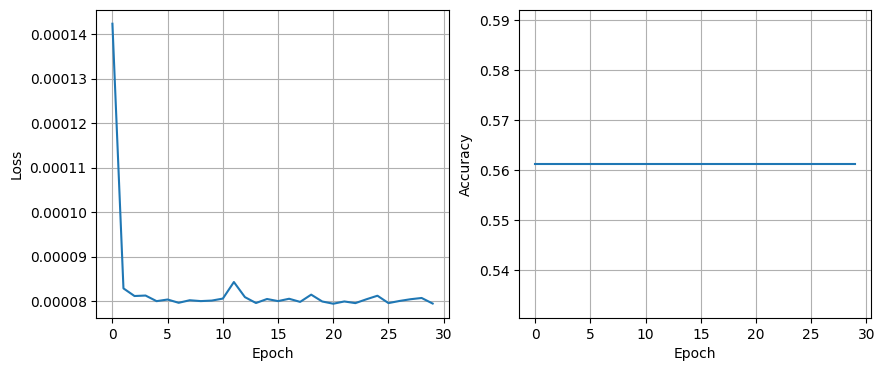

In [ ]:
plot_train_loss_acc(history1)

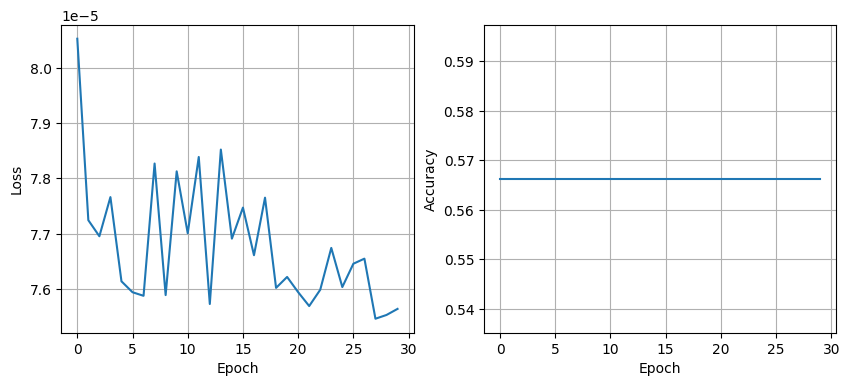

In [ ]:
plot_test_loss_acc(history1)

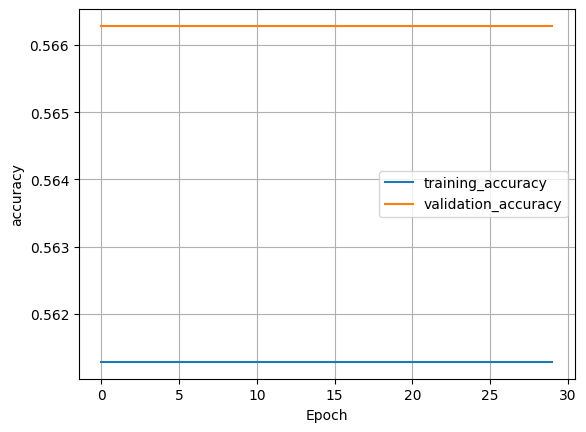

In [ ]:
   plt.plot(history1.history['accuracy'], label='training_accuracy')
   plt.plot(history1.history['val_accuracy'], label='validation_accuracy')

   plt.xlabel('Epoch')
   plt.ylabel('accuracy')
   plt.grid(True)

   plt.legend()
   plt.show()

### Samira Model

In [ ]:
calendar

date  wm_yr_wk    weekday  wday  month  year       d  event_name_1  \
1824 2016-01-27     11552  Wednesday     5      1  2016  d_1825            16   
1825 2016-01-28     11552   Thursday     6      1  2016  d_1826            16   
1826 2016-01-29     11552     Friday     7      1  2016  d_1827            16   
1827 2016-01-30     11601   Saturday     1      1  2016  d_1828            16   
1828 2016-01-31     11601     Sunday     2      1  2016  d_1829            16   
...         ...       ...        ...   ...    ...   ...     ...           ...   
1964 2016-06-15     11620  Wednesday     5      6  2016  d_1965            16   
1965 2016-06-16     11620   Thursday     6      6  2016  d_1966            16   
1966 2016-06-17     11620     Friday     7      6  2016  d_1967            16   
1967 2016-06-18     11621   Saturday     1      6  2016  d_1968            16   
1968 2016-06-19     11621     Sunday     2      6  2016  d_1969             6   

      event_type_1  event_name_2  event_type_2  snap_CA  snap_TX  snap_WI  
1824             4             1             1        0        0        0  
1825             4             1             1        0        0        0  
1826             4             1             1        0        0        0  
1827             4             1             1        0        0        0  
1828             4             1             1        0        0        0  
...            ...           ...           ...      ...      ...      ...  
1964             4             1             1        0        1        1  
1965             4             1             1        0        0        0  
1966             4             1             1        0        0        0  
1967             4             1             1        0        0        0  
1968             3             0             0        0        0        0  

[145 rows x 14 columns]

In [ ]:
sales_train

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
1         CA_1       CA    0    0    0    0  ...       0       0       0   
2         CA_1       CA    0    0    0    0  ...       2       1       2   
3         CA_1       CA    0    0    0    0  ...       1       0       5   
4         CA_1       CA    0    0    0    0  ...       2       1       1   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       2       0       0   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       2       1       0   
30488     WI_3       WI    0    0    0    0  ...       0       0       1   
30489     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
1           0       0       1       0       0       0       0  
2           1       1       1       0       1       1       1  
3           4       1       0       1       3       7       2  
4           0       1       1       2       2       2       4  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       0       0       1       0       0       1  
30486       0       0       0       0       0       1       0  
30487       2       0       1       0       0       1       0  
30488       0       0       1       0       3       1       3  
30489       0       0       0       0       0       0       0  

[30490 rows x 1919 columns]

In [ ]:
sale_price

store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]

In [ ]:
data = time_series_data.transpose()


In [ ]:
data['sales'] = data.sum(axis=1)


In [ ]:
data=data.reset_index()

In [ ]:
data.rename(columns = {'index':'d'}, inplace = True)


In [ ]:
df=data[['d','sales']]

In [ ]:
df

d  sales
0        d_1  32631
1        d_2  31749
2        d_3  23783
3        d_4  25412
4        d_5  19146
...      ...    ...
1908  d_1909  35343
1909  d_1910  35033
1910  d_1911  40517
1911  d_1912  48962
1912  d_1913  49795

[1913 rows x 2 columns]

In [ ]:
df1 = calendar[['d','date']].merge(df, on = ['d'], how = 'left')


In [ ]:
df1= df1.set_index('date')


In [ ]:
df1.drop('d', axis=1, inplace=True)

In [ ]:
df1

sales
date               
2016-01-27  31349.0
2016-01-28  32466.0
2016-01-29  37639.0
2016-01-30  49104.0
2016-01-31  50831.0
...             ...
2016-06-15      NaN
2016-06-16      NaN
2016-06-17      NaN
2016-06-18      NaN
2016-06-19      NaN

[145 rows x 1 columns]

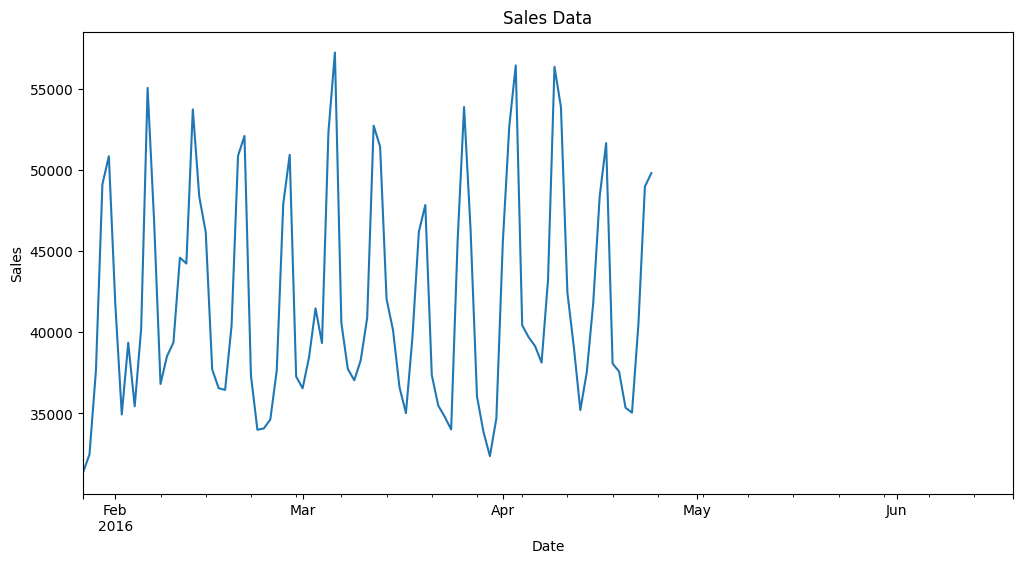

In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Plot the time series data
df1['sales'].plot(figsize=(12, 6))
plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()



In [ ]:
# split data to train and test

# Split the DataFrame
train_data = df1[df1['sales'].notna()]
test_data = df1[df1['sales'].isna()]
test_data = test_data.drop(columns=['sales'])

In [ ]:
train_data

sales
date               
2016-01-27  31349.0
2016-01-28  32466.0
2016-01-29  37639.0
2016-01-30  49104.0
2016-01-31  50831.0
...             ...
2016-04-20  35343.0
2016-04-21  35033.0
2016-04-22  40517.0
2016-04-23  48962.0
2016-04-24  49795.0

[89 rows x 1 columns]

In [ ]:
X_train = train_data[:-28]
X_test = train_data[-28:]



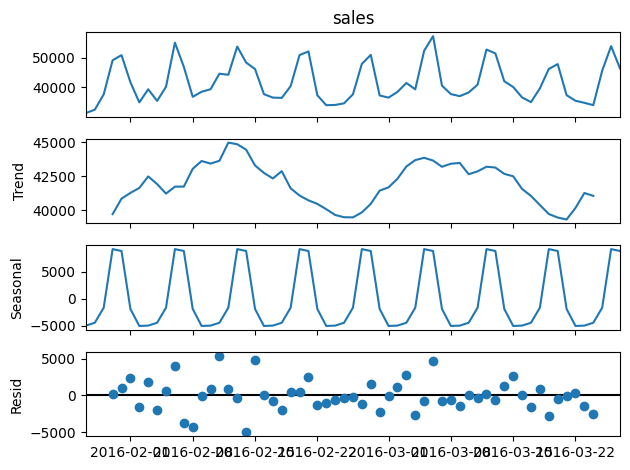

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(X_train['sales'], model='additive')
decomposition.plot()
plt.show()


In [ ]:
# Test for stationarity
result = adfuller(X_train['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical values:')

for key, value in result[4].items():
  print('\t%s: %.4f' % (key, value))

ADF Statistic: -2.6155122339705694
p-value: 0.08983339908690058
Critical values:
	1%: -3.5685
	5%: -2.9214
	10%: -2.5987


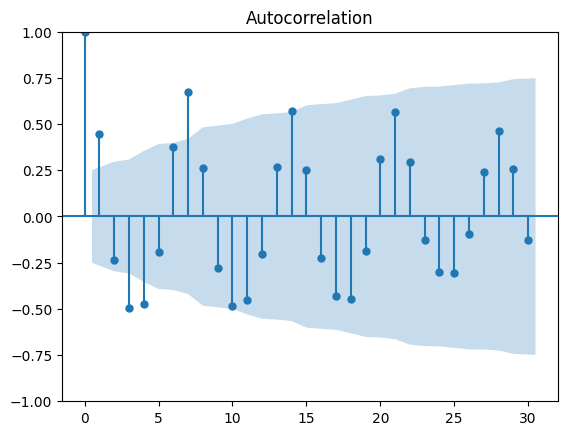

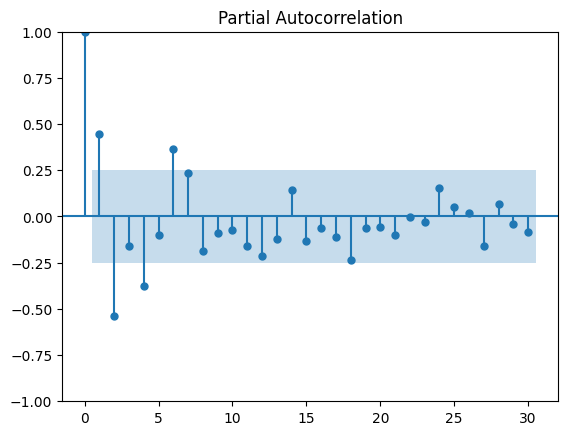

In [ ]:

# Plot ACF and PACF
plot_acf(X_train['sales'], lags=30)
plt.show()
plot_pacf(X_train['sales'], lags=30)
plt.show()

In [ ]:
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error



# Define the range of ARIMA parameters to search
p_values = range(0, 6)  # Autoregressive order
d_values = range(0, 2)  # Differencing order
q_values = range(0, 3)  # Moving average order

best_rmse = float('inf')
best_params = None

# Perform grid search to find the optimal ARIMA parameters
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Fit ARIMA model to the training data
        model = ARIMA(X_train, order=(p, d, q))
        arima_model = model.fit()

        # Make predictions on the test data
        predictions = arima_model.forecast(steps=len(X_test))

        # Calculate RMSE to evaluate the model performance
        rmse = mean_squared_error(X_test, predictions, squared=False)

        # Update the best parameters if RMSE is improved
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (p, d, q)

        print(f'ARIMA({p}, {d}, {q}) - RMSE: {rmse}')

        # If RMSE is below 1, stop searching
        if rmse < 1:
            break

    except:
        continue

print(f'Best Parameters: ARIMA{best_params} - RMSE: {best_rmse}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) - RMSE: 7102.48513972552
ARIMA(0, 0, 1) - RMSE: 7089.720079742299


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(0, 0, 2) - RMSE: 7074.33567954216
ARIMA(0, 1, 0) - RMSE: 8184.1068541411405
ARIMA(0, 1, 1) - RMSE: 7505.981801774591


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(0, 1, 2) - RMSE: 7260.929384119791
ARIMA(1, 0, 0) - RMSE: 7237.06937025874


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(1, 0, 1) - RMSE: 7091.143178614348


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

ARIMA(1, 0, 2) - RMSE: 7046.503074409483
ARIMA(1, 1, 0) - RMSE: 7831.246441619648
ARIMA(1, 1, 1) - RMSE: 7659.504897159677


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 2) - RMSE: 7414.454108097365
ARIMA(2, 0, 0) - RMSE: 6952.530889574611


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA(2, 0, 1) - RMSE: 6346.759222453913


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) - RMSE: 3538.341694920719


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0) - RMSE: 7644.6897188495095


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1) - RMSE: 6917.850146566887


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA(2, 1, 2) - RMSE: 7406.958189337961
ARIMA(3, 0, 0) - RMSE: 6822.643668913319
ARIMA(3, 0, 1) - RMSE: 6287.530046870792


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 0, 2) - RMSE: 3543.062996265288


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 0) - RMSE: 7669.9902747473625


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3, 1, 1) - RMSE: 7600.2052513990675


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA(3, 1, 2) - RMSE: 7191.551385805628


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 0) - RMSE: 5358.826844334765


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 0, 1) - RMSE: 5306.909527953675


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

ARIMA(4, 0, 2) - RMSE: 3424.959341501328
ARIMA(4, 1, 0) - RMSE: 6909.483687730016


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(4, 1, 1) - RMSE: 6272.93192440806


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA(4, 1, 2) - RMSE: 3942.9612049220655
ARIMA(5, 0, 0) - RMSE: 5230.050983143966


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 0, 1) - RMSE: 5104.90994146846


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA(5, 0, 2) - RMSE: 4478.304968960004


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 1, 0) - RMSE: 5741.413992424158


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(5, 1, 1) - RMSE: 5521.3737131765865


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA(5, 1, 2) - RMSE: 3855.9028184059084
Best Parameters: ARIMA(4, 0, 2) - RMSE: 3424.959341501328


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Specify ARIMA parameters (p, d, q)
# These parameters should be chosen based on the characteristics of your data
p = 4  # Autoregressive order
d = 0  # Differencing order
q = 2  # Moving average order

# Fit ARIMA model to the data
arima_model = ARIMA(X_train, order=(p, d, q))
arima_result = arima_model.fit()

# Forecast future daily sales
forecast_steps = 28  # Number of days to forecast
forecast = arima_result.forecast(steps=forecast_steps)

# Print the forecasted values
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2016-03-28    41879.661265
2016-03-29    37921.623400
2016-03-30    34777.195654
2016-03-31    36686.962845
2016-04-01    43195.918485
2016-04-02    48800.461266
2016-04-03    48926.635096
2016-04-04    43685.675404
2016-04-05    37166.036097
2016-04-06    34212.070549
2016-04-07    36983.555983
2016-04-08    43397.131331
2016-04-09    48639.159605
2016-04-10    48769.618338
2016-04-11    43701.228638
2016-04-12    37260.732216
2016-04-13    34293.791285
2016-04-14    37017.728521
2016-04-15    43366.469595
2016-04-16    48558.137306
2016-04-17    48696.085268
2016-04-18    43693.263137
2016-04-19    37325.316528
2016-04-20    34381.241169
2016-04-21    37061.810097
2016-04-22    43334.499480
2016-04-23    48474.553820
2016-04-24    48623.764838
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


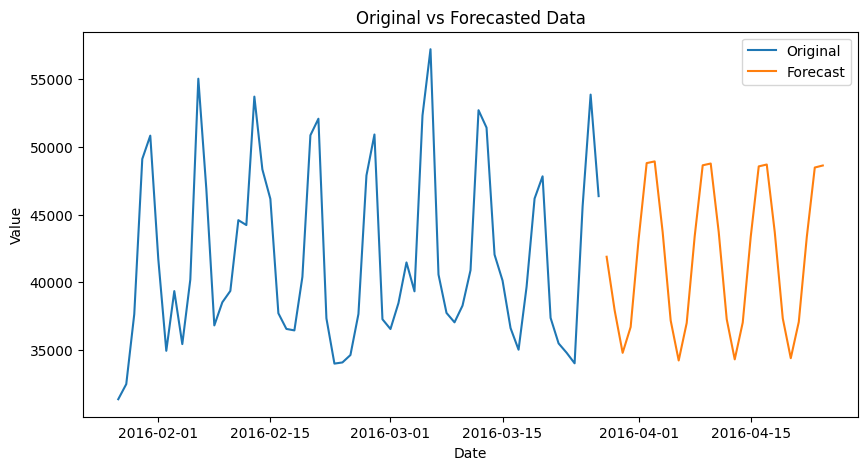

In [ ]:
your_number_of_steps=28
# Plot the original data and forecast
plt.figure(figsize=(10, 5))
plt.plot(X_train.index, X_train['sales'], label='Original')
plt.plot(pd.date_range(start=X_train.index[-1], periods=your_number_of_steps + 1, freq='D')[1:], forecast, label='Forecast')
plt.title('Original vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
pred = arima_model.fit().predict()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


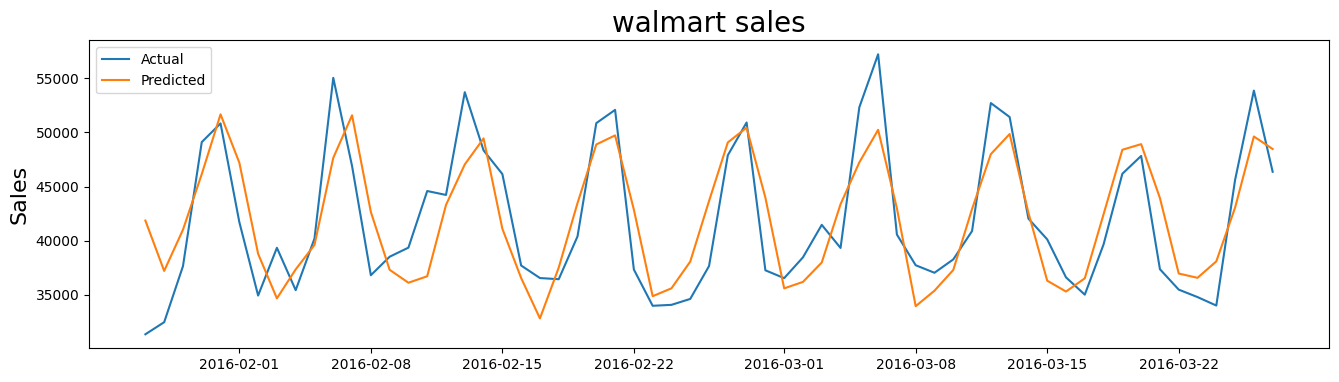

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(X_train, label="Actual")
plt.plot(pred, label="Predicted")
plt.title('walmart sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

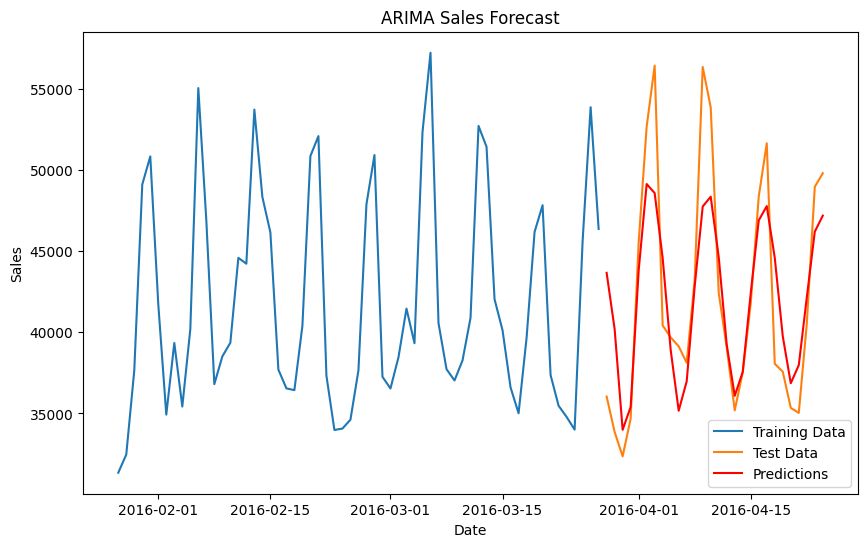

In [ ]:
# Visualize the actual vs. predicted sales
plt.figure(figsize=(10, 6))
plt.plot(X_train.index, X_train, label='Training Data')
plt.plot(X_test.index, X_test, label='Test Data')
plt.plot(X_test.index, predictions, label='Predictions', color='red')
plt.title('ARIMA Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

train_rms = mean_squared_error(X_train, pred, squared=False)
test_rms = mean_squared_error(X_test, predictions, squared=False)

In [ ]:
print(train_rms)
print(test_rms)

3912.691900374387
3855.9028184059084


In [ ]:
from tqdm import tqdm

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error



best_rmse = float('inf')
best_model = None
best_params = None

# Define ranges for parameters to search over
p_values = range(0, 6)  # Autoregressive order
d_values = range(0, 2)  # Differencing order
q_values = range(0, 3)
P_range = [0, 1]
D_range = [0, 1]
Q_range = [0, 1]
s_range = [7]  # Assuming weekly seasonality

for p in tqdm(p_values):
    for d in d_values:
        for q in q_values:
            for P in P_range:
                for D in D_range:
                    for Q in Q_range:
                        for s in s_range:
                            try:
                                # Define and fit the SARIMAX model
                                model = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), trend='ct')
                                result = model.fit()

                                # Forecast future sales
                                forecast = result.forecast(steps=len(X_test))
                                # Calculate RMSE
                                rmse = mean_squared_error(X_test, forecast, squared=False)

                                # Update best model if RMSE improved
                                if rmse < best_rmse:
                                    best_rmse = rmse
                                    best_model = model
                                    best_params = (p, d, q, P, D, Q, s)
                            except:
                                continue

print(best_params)



  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D

(4, 0, 1, 0, 1, 1, 7)


In [ ]:

# Refit the best model using all data
final_model = SARIMAX(X_train, order=best_params[:3], seasonal_order=best_params[3:])
final_result = final_model.fit()

# Forecast future sales
forecast = final_result.get_forecast(steps=28)

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Print forecasted values
print(forecast_values)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2016-03-28    37060.200942
2016-03-29    36498.215492
2016-03-30    35885.283478
2016-03-31    34905.638843
2016-04-01    43583.298895
2016-04-02    51847.881555
2016-04-03    47363.245152
2016-04-04    37591.450666
2016-04-05    36553.540466
2016-04-06    35721.421723
2016-04-07    34837.735198
2016-04-08    43595.042267
2016-04-09    51869.914114
2016-04-10    47366.410618
2016-04-11    37585.338738
2016-04-12    36548.956409
2016-04-13    35720.134537
2016-04-14    34837.430811
2016-04-15    43594.360754
2016-04-16    51868.932778
2016-04-17    47365.513416
2016-04-18    37584.639836
2016-04-19    36548.386275
2016-04-20    35719.626564
2016-04-21    34836.970095
2016-04-22    43593.952417
2016-04-23    51868.576600
2016-04-24    47365.202494
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


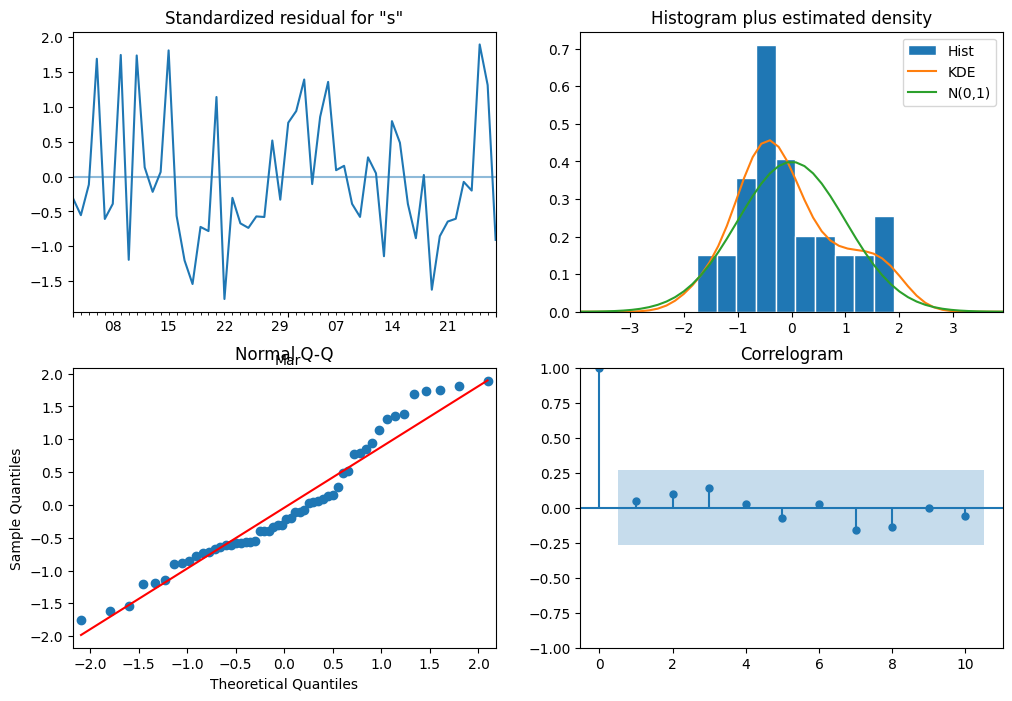

In [ ]:
# Fit SARIMA model
order = (4, 0, 1)
seasonal_order = (0, 1, 1, 7)
model = SARIMAX(X_train['sales'], order=order, seasonal_order=seasonal_order)
results = model.fit()
preds = model.fit().predict()

# Check residuals
results.plot_diagnostics(figsize=(12, 8))
plt.show()




In [ ]:

# Forecast sales for the next 28 days
forecast = results.forecast(steps=28)
print(forecast)

2016-03-28    37060.200942
2016-03-29    36498.215492
2016-03-30    35885.283478
2016-03-31    34905.638843
2016-04-01    43583.298895
2016-04-02    51847.881555
2016-04-03    47363.245152
2016-04-04    37591.450666
2016-04-05    36553.540466
2016-04-06    35721.421723
2016-04-07    34837.735198
2016-04-08    43595.042267
2016-04-09    51869.914114
2016-04-10    47366.410618
2016-04-11    37585.338738
2016-04-12    36548.956409
2016-04-13    35720.134537
2016-04-14    34837.430811
2016-04-15    43594.360754
2016-04-16    51868.932778
2016-04-17    47365.513416
2016-04-18    37584.639836
2016-04-19    36548.386275
2016-04-20    35719.626564
2016-04-21    34836.970095
2016-04-22    43593.952417
2016-04-23    51868.576600
2016-04-24    47365.202494
Freq: D, Name: predicted_mean, dtype: float64


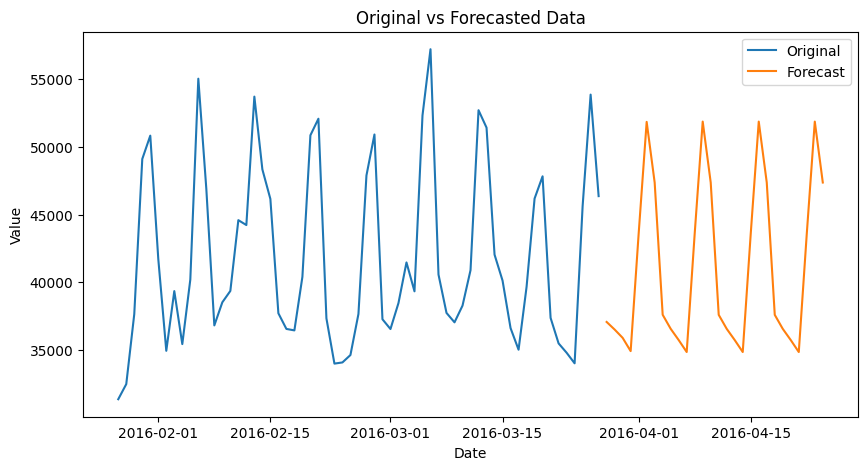

In [ ]:
your_number_of_steps=28
# Plot the original data and forecast
plt.figure(figsize=(10, 5))
plt.plot(X_train.index, X_train['sales'], label='Original')
plt.plot(pd.date_range(start=X_train.index[-1], periods=your_number_of_steps + 1, freq='D')[1:], forecast, label='Forecast')
plt.title('Original vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

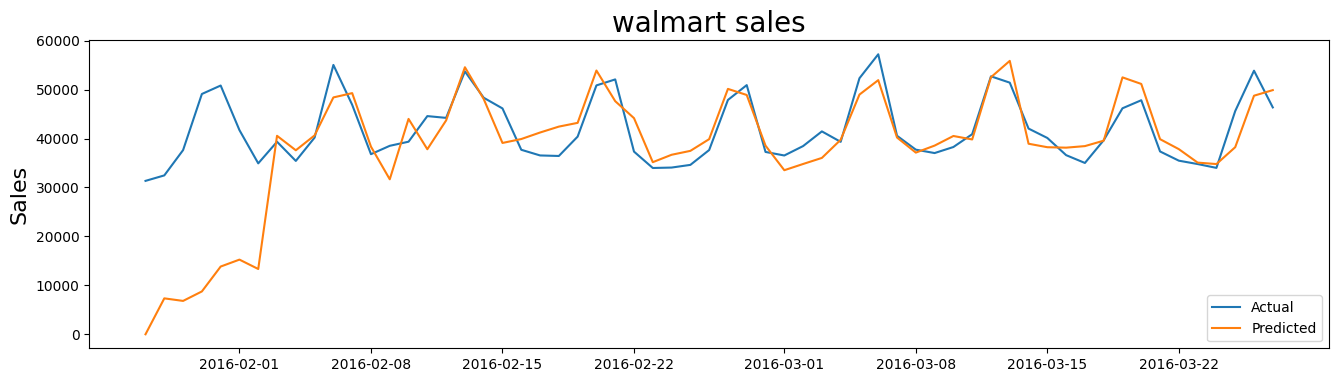

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(X_train, label="Actual")
plt.plot(preds, label="Predicted")
plt.title('walmart sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

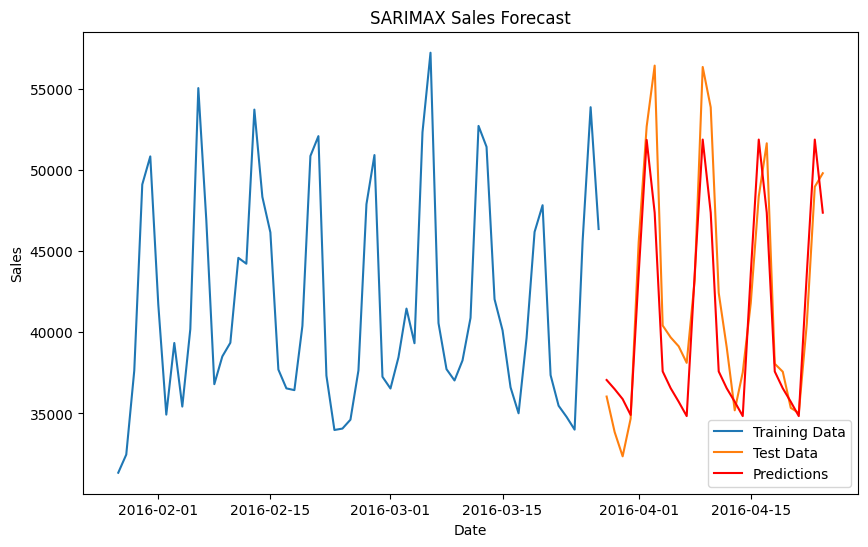

In [ ]:
# Visualize the actual vs. predicted sales
plt.figure(figsize=(10, 6))
plt.plot(X_train.index, X_train, label='Training Data')
plt.plot(X_test.index, X_test, label='Test Data')
plt.plot(X_test.index, forecast_values, label='Predictions', color='red')
plt.title('SARIMAX Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
test_rmse = mean_squared_error(X_test, forecast_values, squared=False)
print(f"Test loss for samirax: {test_rmse}")

Test loss for samirax: 3305.476146532189
